# Data work

In [1]:
# pip install datareader
import time 
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import random
import numpy as np
from datetime import datetime, timedelta, date

### Get price data

In [2]:
date=pd.to_datetime('1/1/2010')
today=pd.to_datetime('2/2/2019')
assets = ['FXE', 'SPY', 'GLD', 'BND', 'USO', 'FXB', 'FXY', 'CYB']
raw_assets = pd.DataFrame()
err = []
for i in range(len(assets)):
    try:
        raw_assets[assets[i]] = web.DataReader(assets[i],'yahoo', date, today)["Close"]
    except:
        err.append(assets[i])



FXE


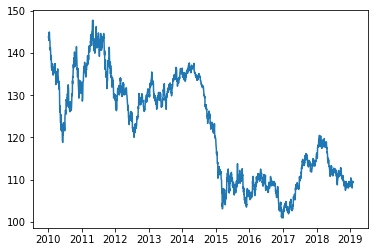

SPY


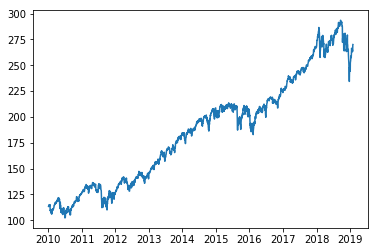

GLD


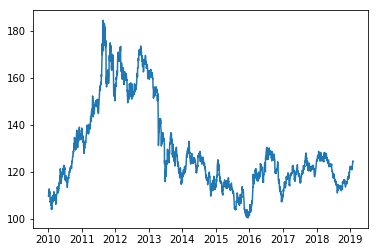

BND


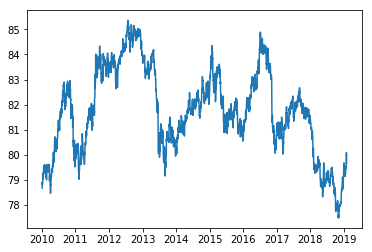

USO


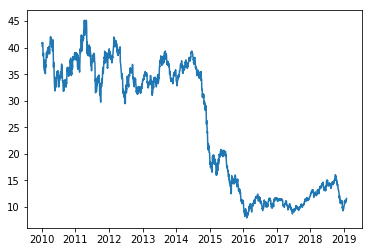

FXB


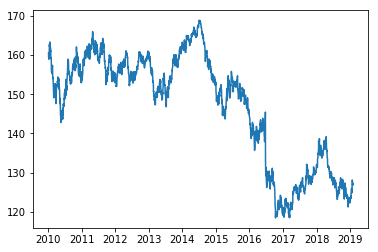

FXY


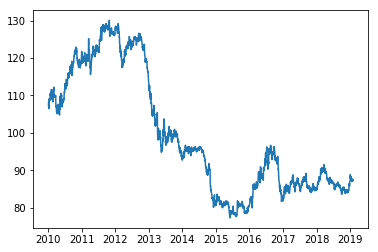

CYB


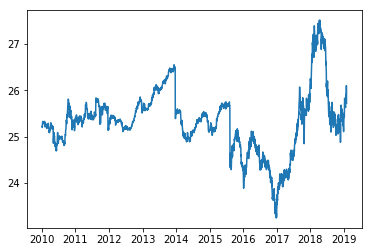

In [3]:
for a in assets:
    print(a)
    plt.plot(raw_assets[a])
    plt.show()

### Get daily, weekly and monthly returns and convert to binary up/down

In [4]:
###Past returns
#daily pct
Daily = raw_assets.pct_change(periods = 1)
D_bin = Daily > 0

# 5 traind day pct
Weekly = raw_assets.pct_change(periods = 5)
W_bin = Weekly > 0

# 20 trading day pct
Monthly = raw_assets.pct_change(periods = 20)
M_bin = Monthly > 0

### Get rolling cross correlations for prev 20 trading days

In [6]:
mo = 20  #a month of trading days
name=""
names = []
for a in range(len(assets)):
    for aa in range( (a+1), len(assets) ):
        name = "c_" + assets[a] + assets[aa]
        names.append(name)

In [7]:
D_Matrix = np.empty(shape= [len(Daily),len(names)])        
D_Matrix[:,:] = np.NaN
D_Matrix.shape

(2286, 28)

In [8]:
for i in range((mo+1), len(Daily)):
    period = Daily.iloc[i-20:i]
    p_corrs = period.corr()
    
    for a in range(len(assets)):
        for aa in range( (a+1), len(assets) ):
            name = "c_" + assets[a] + assets[aa]
            name_ind = names.index(name)
            p_corr = p_corrs[assets[a]][assets[aa]]
            D_Matrix[i][name_ind] = p_corr

D_corr=pd.DataFrame(D_Matrix, columns = names, index=Daily.index)

D_corr_bin = D_corr >0

### Get autocorrelations at lag 1


In [9]:
D_acM = np.empty(shape= [len(Daily),len(assets)])        
D_acM[:,:] = np.NaN
D_acM.shape

(2286, 8)

In [10]:
assets2 = ["ac_" + a for a in assets]

In [11]:
for i in range((mo+2), len(Daily)):
    period1 = Daily.iloc[i-21:i-1]
    period2 = Daily.iloc[i-20:i]
    for a in assets:
        ac1 = np.corrcoef(period1[a], period2[a])[0,1]
        col_ind = assets.index(a)
        D_acM[i][col_ind] = ac1
D_ac = pd.DataFrame(D_acM, columns = assets2, index=Daily.index)
D_ac_bin = D_ac >0

### Join all variables

In [12]:
All_bin = pd.concat([D_bin, W_bin, M_bin, D_corr_bin, D_ac_bin], axis=1) *1

for i in range(All_bin.shape[0]):
    for j in range(All_bin.shape[1]):
        All_bin.iloc[i][j] = ((All_bin.iloc[i,j] * 2)-1)

        All_bin.iloc[i][j] = All_bin.iloc[i][j] / abs(All_bin.iloc[i][j])   

In [13]:

All_bin.columns = ['FXE', 'SPY', 'GLD', 'BND', 'USO', 'FXB', 'FXY', 'CYB', 
                   'W_FXE', 'W_SPY', 'W_GLD', 'W_BND', 'W_USO', 'W_FXB', 'W_FXY', 'W_CYB', 
                   'M_FXE', 'M_SPY', 'M_GLD', 'M_BND', 'M_USO', 'M_FXB', 'M_FXY', 'M_CYB', 
                   'c_FXESPY', 'c_FXEGLD', 'c_FXEBND', 'c_FXEUSO', 'c_FXEFXB', 'c_FXEFXY', 'c_FXECYB', 
                   'c_SPYGLD', 'c_SPYBND', 'c_SPYUSO', 'c_SPYFXB', 'c_SPYFXY', 'c_SPYCYB', 
                   'c_GLDBND', 'c_GLDUSO', 'c_GLDFXB', 'c_GLDFXY', 'c_GLDCYB', 
                   'c_BNDUSO', 'c_BNDFXB', 'c_BNDFXY', 'c_BNDCYB', 
                   'c_USOFXB', 'c_USOFXY', 'c_USOCYB', 
                   'c_FXBFXY', 'c_FXBCYB',
                   'c_FXYCYB', 
                   'ac_FXE', 'ac_SPY', 'ac_GLD', 'ac_BND', 'ac_USO', 'ac_FXB', 'ac_FXY', 'ac_CYB']


# Genetic Algorithm
# Training

# Initialize()

In [14]:
def create_class():
    global Trader, strategy
    class Trader:
        def __init__(self, number, strategy, trades):
            self.strategy = strategy  #binary string
            self.trades = []
            self.trade_dates = []
            self.number = number


In [15]:
def init_strat():
    #percent that a variable is irrelevant

    global strategy, n_traders, Variables, irrelevant
    Variables = All_bin.shape[1]
    strategy = []
    strategy = np.empty(shape=[n_traders,Variables], dtype=int)

    #create initial strategies
    for i in range(n_traders):
        for j in range(Variables):
            if(random.random() < irrelevant):
                strategy[i,j] = 0
            elif(random.random() <= .5):
                strategy[i,j] = 1
            else:
                strategy[i,j] = -1


In [16]:
def create_inst():
    #create trader list
    global Trader_list, n_traders
    Trader_list =[]
    for i in range(n_traders):
        a_trader = Trader(i, strategy[i], 0)
        Trader_list.append(a_trader)

In [17]:
def reset_stats():
    #Create all global vars that will be tracked/updated
    global irrel_pct, dec_vars, composition, max_return, avg_return, min_return, max_trades, avg_trades, min_trades,\
    top5strats, top5tradehist, c_trades_returns, c_trades_dvars, n_of_trades, result_list, Save_all_winners, top_gen_trades, \
    top_gen_trade_dates, top_gen_ntrades, top_gen_return, top_gen_strategy, top_gen_str_strategy
    
    irrel_pct = []  #max, min, sd?
    dec_vars = []

    composition = []

    max_return = []
    avg_return = []
    min_return = []

    max_trades = []
    avg_trades = []
    min_trades = []

    top_gen_trades = []
    top_gen_trade_dates= []
    top_gen_ntrades = []
    top_gen_return = []    
    top_gen_strategy = []
    top_gen_str_strategy = []
    top_to_array = []
    c_trades_returns = []
    c_trades_dvars = []
    
    Save_all_winners = pd.DataFrame(columns=['trades', 'ntrades', 'return', 'strategy'])

    #Global but overwritten each generation
    n_of_trades = []
    result_list = []
    
    run = ''


In [18]:
def initialize(n_traders, Mutation, irrelevant, weight_exponent):
    global seed
    random.seed(a=seed)
    create_class()
    init_strat()
    create_inst()
    reset_stats()

# Loop()

In [19]:
def calc_fitness(start_day, end_day):
    global Trader_list, strategy
    #i trading day
    #j trader
    
    for i in range(start_day, end_day):
        for j in range(len(Trader_list)):
            strat_match = sum(np.asarray(All_bin.iloc[i]) * strategy[j])
            buylogic = sum(abs(strategy[j]))
            
            if(strat_match == buylogic):
                buy_result = Daily.FXE[i+1] - spread
                Trader_list[j].trades.append(buy_result)
                Trader_list[j].trade_dates.append(i)
                

In [20]:
def get_stats():
    global n_of_trades, result_list, n_traders, Trader_list
    n_of_trades = []
    result_list = []

    #create lists to get stats from
    for t in Trader_list:
        n_of_trades.append(len(t.trades))
        result_list.append(sum(t.trades))

    #get return composition
    pos_traders = 0
    neg_traders = 0
    unch_traders = 0
    for t in Trader_list:
        if (sum(t.trades) > 0):
            pos_traders = pos_traders+1
        if (sum(t.trades) < 0):
            neg_traders = neg_traders+1
        if (sum(t.trades) == 0):
            unch_traders = unch_traders+1
    composition.append([pos_traders, neg_traders, unch_traders])
    
    
    #best worst and avg result
    max_return.append(max(result_list))
    avg_return.append(np.mean(result_list))
    min_return.append(min(result_list))

    #best worst and avg number of trades
    max_trades.append(max(n_of_trades))
    avg_trades.append(np.mean(n_of_trades))
    min_trades.append(min(n_of_trades))

In [21]:
def get_wins():
    global Save_all_winners, top50,  top_gen_trades, top_gen_trade_dates, \
    top_gen_ntrades, top_gen_return, top_gen_strategy, top_gen_str_strategy

    sort_return = []
    sort_trades = []
    sort_trade_dates = []
    sort_ntrades = []
    sort_strategy = []
    sort_string_strategy = []
    
    
    top50 = pd.DataFrame()
    
    
    
    for t in Trader_list:
        sort_return.append(sum(t.trades))
        sort_trades.append(t.trades)
        sort_trade_dates.append(t.trade_dates)
        sort_ntrades.append(len(t.trades))
        sort_strategy.append(t.strategy)
        sort_string_strategy.append(str(t.strategy))

    top50['trades'] = sort_trades
    top50['ntrades'] = sort_ntrades
    top50['trade_dates'] = sort_trade_dates
    top50['return'] = sort_return
    top50['strategy'] = sort_strategy
    top50['str_strategy'] = sort_string_strategy
    top50.sort_values(axis=0,by='return',ascending=False, inplace=True)
    top50.drop_duplicates(subset='str_strategy',inplace=True)

    
    top_gen_trades.append(top50['trades'].iloc[0])
    top_gen_trade_dates.append(top50['trade_dates'].iloc[0])
    top_gen_ntrades.append(top50['ntrades'].iloc[0])
    top_gen_return.append(top50['return'].iloc[0])
    top_gen_strategy.append(top50['strategy'].iloc[0])
    top_gen_str_strategy.append(str(top50['strategy'].iloc[0]))


In [22]:
#winners move on, weighted by exponent
def crossover():
    global result_list, weight_exponent, selection_weights, strategy, seed
    random.seed(seed)
    #weight probabilities
    selection_weights = np.empty(shape=[len(result_list)], dtype=float)

    for i in range(n_traders):
        weight=0
        if (result_list[i] > 0):
            weight = ((1+result_list[i])**weight_exponent)
            selection_weights[i] = weight
        else:
            selection_weights[i] = 0.0001 #in case nobody makes money it doesnt like to divide by zero
       
    selection_weights = selection_weights/selection_weights.sum() 
   
    #clear strategy list
    strategy = np.empty((n_traders, Variables), dtype=int)
    
    #mate
    stratcount = 0
    while stratcount< n_traders:
        parents = np.random.choice(Trader_list, size=2, replace=True, p=selection_weights)
        child_strat = np.append(parents[0].strategy[0:int(Variables/2)] , parents[0].strategy[int(Variables/2):Variables])
        if sum(np.absolute(child_strat))==0:
            pass
        else:
            strategy[stratcount,:] = child_strat
            stratcount+=1
    



In [23]:
#mutation based on set rate and original prevalence of -, 1 and 0

def mutation():
    global strategy, Mutation, seed
    random.seed(seed)
    mut_possibilities = [0, -1, 1]
    mut_weights = [irrelevant, ((1-irrelevant)/2), ((1-irrelevant)/2)] #any reason for this distribution?
    #mut_weights = [1/3,1/3,1/3] 
    
    mutation_total = int(strategy.shape[0] * strategy.shape[1] * Mutation/100)
    for i in range(mutation_total):
        mutation_instance = np.random.choice(mut_possibilities, size=1, replace=True, p=mut_weights)
        row = random.randint(0,strategy.shape[0]-1)
        col = random.randint(0,strategy.shape[1]-1)
        strategy[row][col] = mutation_instance
        
    

In [24]:
#load new strategies to new generation
def new_pop():
    global n_traders, Trader_list, strategy
    for i in range(n_traders):
        Trader_list[i].strategy = strategy[i]
        Trader_list[i].trades = []
        Trader_list[i].trade_dates = []



In [25]:
def loop(start_day, end_day):
    calc_fitness(start_day,end_day)
    get_stats()
    get_wins()
    crossover()
    mutation()
    new_pop()

# Train() function

In [26]:
def Train(n_traders, Mutation, irrelevant, weight_exponent, start_day, end_day, stopper):
    global max_return,secs, run, seed
    
    print('train days:',start_day,'-',end_day)
    run = str(n_traders)+'/'+str(irrelevant)+'/'+str(Mutation)+'/'+str(weight_exponent)
    print('Run: ', run, '\t', 'Traders/Irrelevant/Mutation/Exponent')

    start_all = time.time()
    
    initialize(n_traders, Mutation, irrelevant, weight_exponent)
    i = 1
    while True:
        start = time.time()
        loop(start_day, end_day)
        end = time.time()
        print('gen',i,'\t', 
              'max:',
              round(max_return[-1],3)*100,'% ', '\t',
              'avg:',
              round(avg_return[-1],3)*100,'%', '\t',
              'time:',
              str(round(end-start,2))+'s')
        i += 1
    
        if (len(max_return) > stopper):
            stopping_criteria = []
            for j in range(2,stopper+1):
                stopping_criteria.append(abs(max_return[-1]-max_return[-j]))   
            if max(stopping_criteria) < 0.00001:
                print('¯\_(ツ)_/¯  - stopping because', stopper, 'gens convergance')
                break
        if i == (max_generations+1):
            print('¯\_(ツ)_/¯  - stopping because max gens =',max_generations)
            break
    end_all = time.time()
    secs=str(round(end_all-start_all,2))
    print('Total Time: ',secs+'s')
    print('Max achieved at gen: ', max_return.index(max(max_return))+1)
    print('Stopping criteria in gen:',i-1)
    plt.plot(max_return)
    plt.plot(avg_return)
    plt.show()




# Testing

In [27]:
def create_testers():
    global Tester_list, Tester
    Tester_list = []

    class Tester:
        def __init__(self, name, strategy, orig_return):
            self.strategy = strategy  #binary array
            self.trades = []
            self.trade_dates = []
            self.name = name
            self.orig_return = orig_return
            self.new_return = 0
            self.dvars = 0

In [40]:
def add_BestGAs():
    global Tester_list
    Tester_list=[]
    #add best GA from last Run
    Converged = Tester('Converged',top50.strategy.iloc[0],top50['return'].iloc[0])
    Tester_list.append(Converged)

# these were attempts to get around overfitting...

#add older GA?  will this be neccesary?
#     global topgen
#     topgen = pd.DataFrame()

#     topgen['trades'] = top_gen_trades
#     topgen['trade_dates'] = top_gen_trade_dates
#     topgen['ntrades'] = top_gen_ntrades
#     topgen['return'] = top_gen_return
#     topgen['strategy'] = top_gen_strategy
#     topgen['str_strategy'] = top_gen_str_strategy

#     topgen.sort_values(axis=0,by='return',ascending=False, inplace=True)
#     topgen.drop_duplicates(subset='str_strategy',inplace=True)
    
#     BestGen = Tester('BestGen',topgen.strategy.iloc[0],topgen['return'].iloc[0])
#     Tester_list.append(BestGen)

#     #grab 4,3,2,1 variable strategies from top 50
#     var_target=4
#     for s in range(5,50):
#         include = s
    
#         super50EZ_set = top50.strategy.iloc[0:50]
#         super50EZ_strat = np.empty(shape=[Variables],dtype=int)

#         #adj to lower frequency needed for decision variables
#         for i in range(Variables):
#             zero = 0
#             one = 0
#             irr = 0
#             for j in super50EZ_set:
#                 if (j[i] == 0):
#                     irr += 1
#                 elif (j[i] == -1):
#                     zero += 1
#                 elif (j[i] == 1):
#                     one += 1
#             if max(one,zero) >= include:
                
#                 if max(one,zero) == one:
#                     super50EZ_strat[i] = 1
#                 if max(one,zero) == zero:
#                     super50EZ_strat[i] = -1

#             else:
#                 super50EZ_strat[i] = 0
   
#         super_dvars = sum(np.absolute(super50EZ_strat))
        
#         if super_dvars < var_target:
#             var_target = var_target-1
#             if var_target == 0:
#                 break
        
#         if super_dvars == var_target:
#             Super50EZ = Tester(str(super_dvars)+'vars',super50EZ_strat,'na')
#             Tester_list.append(Super50EZ)
#             var_target = var_target-1
#             if var_target == 0:
#                 break

    #add number of decision variables for each tester
    for t in Tester_list:
        t.dvars = sum(np.absolute(t.strategy))


In [29]:
def test_fitness(test_start_day, test_end_day, Tester_list):
    
    #i trading day
    #j trader
    
    for i in range(test_start_day, test_end_day):
        for j in Tester_list:
            strat_match = sum (np.asarray(All_bin.iloc[i]) * j.strategy)
            
            buylogic = sum(abs(j.strategy))
            
            if(strat_match == buylogic):
                buy_result = Daily.FXE[i+1] - spread
                j.trades.append(buy_result)
                j.trade_dates.append(i)
                
    for d in Tester_list:
        d.new_return = sum(d.trades)

# Test() function

In [30]:
def Test(test_start_day, test_end_day):
    
    print('test days:',test_start_day,'-',test_end_day)
    
    create_testers()
    
    add_BestGAs()
    
    test_fitness(test_start_day=test_start_day, test_end_day=test_end_day, Tester_list=Tester_list) 
    
    
    #summary of results
    print('name\t',  '     dec vars\t','train return\t', 'test return\t',' trades\t')

    for i in Tester_list:
        if(isinstance(i.orig_return, str)):
            print(i.name+'   \t    ', 
                  i.dvars,'\t      ',
                  '      ', '\t      ',  
                  round(i.new_return*100,1),'%\t    ',
                  len(i.trades),'\t '
                 )
        else:
            print(i.name+'   \t    ',  
                  i.dvars,'\t      ',
                  round(i.orig_return*100, 1), '%  \t      ', 
                  round(i.new_return*100,1),'%\t    ',
                  len(i.trades),'\t '
                                   )

    
    #creates equity curve as if the trader bets 100 units every time
    Equity_curves = pd.DataFrame()
    for i in Tester_list:
        ec_temp = [100]
        for day in range(test_start_day, test_end_day+1):
            if day in i.trade_dates:
                ec_temp.append(ec_temp[-1]+i.trades[i.trade_dates.index(day)]*100)

            else:
                ec_temp.append(ec_temp[-1])




        Equity_curves[i.name] = ec_temp


    for i in Tester_list:    
        plt.plot(Equity_curves[i.name], label=i.name)
        plt.legend()
    plt.show()

    #detail on trader strategies and results
    for i in Tester_list:
        print(i.name, '\tdecision vars:',i.dvars, '\treturn',round(sum(i.trades)*100,1),              )

        names_of_vars = [        'day chg in FXE','day chg in SPY','day chg in GLD','day chg in BND','day chg in USO','day chg in FXB','day chg in FXY','day chg in CYB',
                                 'wk chg in FXE',       'wk chg in SPY',    'wk chg in GLD',    'wk chg in BND',    'wk chg in USO',    'wk chg in FXB',    'wk chg in FXY',    'wk chg in CYB',
                                 'mo chg in FXE',       'mo chg in SPY',    'mo chg in GLD',    'mo chg in BND',    'mo chg in USO',    'mo chg in FXB',    'mo chg in FXY',    'mo chg in CYB', 
                                 'FXESPY corr', 'FXEGLD corr', 'FXEBND corr', 'FXEUSO corr', 'FXEFXB corr', 'FXEFXY corr', 'FXECYB corr', 
                                 'SPYGLD corr', 'SPYBND corr', 'SPYUSO corr', 'SPYFXB corr', 'SPYFXY corr', 'SPYCYB corr', 
                                 'GLDBND corr', 'GLDUSO corr', 'GLDFXB corr', 'GLDFXY corr', 'GLDCYB corr', 
                                 'BNDUSO corr', 'BNDFXB corr', 'BNDFXY corr', 'BNDCYB corr', 
                                 'USOFXB corr', 'USOFXY corr', 'USOCYB corr', 
                                 'FXBFXY corr', 'FXBCYB corr',
                                 'FXYCYB corr', 
                                 'FXE autocor',     'SPY autocor',   'GLD autocor',   'BND autocor',   'USO autocor',   'FXB autocor',   'FXY autocor',   'CYB autocor']
        for j in range(len(i.strategy)):
            if i.strategy[j] == 1:
                print('+',names_of_vars[j])
            if i.strategy[j] == -1:
                print('-',names_of_vars[j])
        print('\n')

#         print(i.name, 'trade results',  round(i.new_return*100,1),'%')
#         plt.scatter( y=i.trades, x=i.trade_dates)
#         plt.show()

#         print(i.name, 'return historgram',  round(i.new_return*100/len(i.trades),3),'% average')
#         plt.hist(i.trades)
#         plt.show()

#         print(i.name, 'trade result autocorrelation')
#         print(np.corrcoef(i.trades[0:-1],i.trades[1:])[0,1])
#         plt.scatter(i.trades[0:-1],i.trades[1:])
#         plt.show()
        

    
    


# Test on all data to get good parameters 

In [31]:
#Parameters
start_day = 20  #do not start before this day because previous month variables do not exist <20
end_day = start_day + 59  

n_traders_opt =  [100, 500]
irrelevant_opt = [.8, .95]
Mutation_opt =  [ 3, 20]
weight_exponent_opt = [7, 20]
spread = 0.000001
max_generations = 50
stopper = 7  #average going down seems to be quicker stopper
seed=33

train days: 20 - 79
Run:  100/0.8/3/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 0.5 %  	 avg: -0.0 % 	 time: 1.03s
gen 2 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.97s
gen 3 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.79s
gen 4 	 max: 1.5 %  	 avg: 0.5 % 	 time: 0.79s
gen 5 	 max: 1.5 %  	 avg: 0.5 % 	 time: 0.79s
gen 6 	 max: 2.1 %  	 avg: 0.6 % 	 time: 0.75s
gen 7 	 max: 2.1 %  	 avg: 0.7 % 	 time: 0.76s
gen 8 	 max: 2.1 %  	 avg: 0.7 % 	 time: 0.79s
gen 9 	 max: 2.1 %  	 avg: 0.7 % 	 time: 0.76s
gen 10 	 max: 2.1 %  	 avg: 0.8 % 	 time: 0.77s
gen 11 	 max: 2.1 %  	 avg: 0.7 % 	 time: 0.75s
gen 12 	 max: 2.1 %  	 avg: 0.8 % 	 time: 0.75s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  9.7s
Max achieved at gen:  6
Stopping criteria in gen: 12


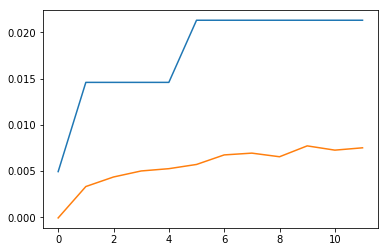

train days: 20 - 79
Run:  100/0.8/3/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 0.5 %  	 avg: -0.0 % 	 time: 0.81s
gen 2 	 max: 1.1 %  	 avg: 0.3 % 	 time: 0.78s
gen 3 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.78s
gen 4 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.77s
gen 5 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.74s
gen 6 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.78s
gen 7 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.75s
gen 8 	 max: 1.5 %  	 avg: 0.4 % 	 time: 0.81s
gen 9 	 max: 1.5 %  	 avg: 0.5 % 	 time: 0.75s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  6.98s
Max achieved at gen:  3
Stopping criteria in gen: 9


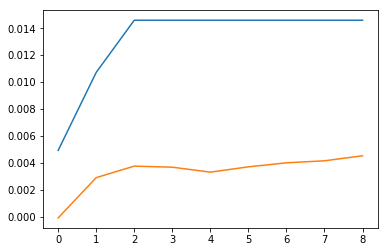

train days: 20 - 79
Run:  100/0.8/20/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 0.5 %  	 avg: -0.0 % 	 time: 0.79s
gen 2 	 max: 2.1 %  	 avg: 0.2 % 	 time: 0.8s
gen 3 	 max: 2.8 %  	 avg: 0.1 % 	 time: 0.98s
gen 4 	 max: 2.8 %  	 avg: 0.2 % 	 time: 0.81s
gen 5 	 max: 2.1 %  	 avg: 0.2 % 	 time: 0.82s
gen 6 	 max: 2.1 %  	 avg: 0.3 % 	 time: 0.89s
gen 7 	 max: 2.1 %  	 avg: 0.2 % 	 time: 0.82s
gen 8 	 max: 2.1 %  	 avg: 0.3 % 	 time: 0.79s
gen 9 	 max: 2.2 %  	 avg: 0.2 % 	 time: 0.81s
gen 10 	 max: 2.1 %  	 avg: 0.2 % 	 time: 0.81s
gen 11 	 max: 2.1 %  	 avg: 0.3 % 	 time: 0.79s
gen 12 	 max: 2.1 %  	 avg: 0.1 % 	 time: 0.79s
gen 13 	 max: 2.8 %  	 avg: 0.2 % 	 time: 0.81s
gen 14 	 max: 2.5 %  	 avg: 0.3 % 	 time: 0.78s
gen 15 	 max: 3.4 %  	 avg: 0.2 % 	 time: 0.87s
gen 16 	 max: 3.4 %  	 avg: 0.4 % 	 time: 0.79s
gen 17 	 max: 2.4 %  	 avg: 0.2 % 	 time: 0.78s
gen 18 	 max: 3.3 %  	 avg: 0.4 % 	 time: 0.8s
gen 19 	 max: 2.5 %  	 avg: 0.4 % 	 time: 0.8s
gen 20 	 max: 2.8 %  

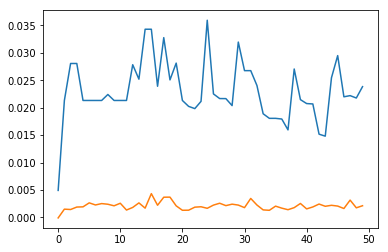

train days: 20 - 79
Run:  100/0.8/20/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 0.5 %  	 avg: -0.0 % 	 time: 0.79s
gen 2 	 max: 1.8 %  	 avg: 0.1 % 	 time: 1.0s
gen 3 	 max: 2.3 %  	 avg: 0.1 % 	 time: 0.8s
gen 4 	 max: 1.5 %  	 avg: 0.0 % 	 time: 0.81s
gen 5 	 max: 1.8 %  	 avg: 0.1 % 	 time: 0.83s
gen 6 	 max: 1.6 %  	 avg: 0.2 % 	 time: 0.83s
gen 7 	 max: 1.9 %  	 avg: 0.1 % 	 time: 0.78s
gen 8 	 max: 1.9 %  	 avg: 0.2 % 	 time: 0.8s
gen 9 	 max: 3.0 %  	 avg: 0.2 % 	 time: 0.8s
gen 10 	 max: 2.0 %  	 avg: 0.1 % 	 time: 0.79s
gen 11 	 max: 2.5 %  	 avg: 0.3 % 	 time: 0.81s
gen 12 	 max: 2.5 %  	 avg: 0.2 % 	 time: 0.79s
gen 13 	 max: 2.6 %  	 avg: 0.4 % 	 time: 0.89s
gen 14 	 max: 2.2 %  	 avg: 0.4 % 	 time: 1.16s
gen 15 	 max: 2.2 %  	 avg: 0.3 % 	 time: 0.8s
gen 16 	 max: 2.2 %  	 avg: 0.2 % 	 time: 1.08s
gen 17 	 max: 2.5 %  	 avg: 0.2 % 	 time: 0.87s
gen 18 	 max: 2.2 %  	 avg: 0.3 % 	 time: 0.8s
gen 19 	 max: 2.6 %  	 avg: 0.2 % 	 time: 1.04s
gen 20 	 max: 2.6 %  	 

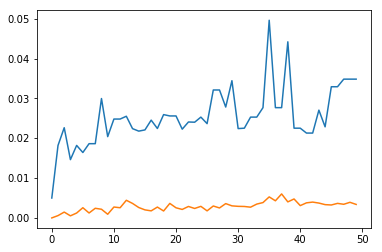

train days: 20 - 79
Run:  100/0.95/3/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.9 %  	 avg: -1.3 % 	 time: 0.85s
gen 2 	 max: 1.9 %  	 avg: 0.4 % 	 time: 0.8s
gen 3 	 max: 1.9 %  	 avg: 0.3 % 	 time: 0.79s
gen 4 	 max: 1.9 %  	 avg: 0.3 % 	 time: 0.82s
gen 5 	 max: 1.6 %  	 avg: 0.3 % 	 time: 0.78s
gen 6 	 max: 1.6 %  	 avg: 0.3 % 	 time: 0.78s
gen 7 	 max: 1.6 %  	 avg: 0.2 % 	 time: 0.81s
gen 8 	 max: 1.6 %  	 avg: 0.2 % 	 time: 0.78s
gen 9 	 max: 1.6 %  	 avg: 0.3 % 	 time: 0.78s
gen 10 	 max: 1.6 %  	 avg: 0.3 % 	 time: 0.78s
gen 11 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.78s
gen 12 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.78s
gen 13 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.79s
gen 14 	 max: 1.5 %  	 avg: 0.3 % 	 time: 0.78s
gen 15 	 max: 2.5 %  	 avg: 0.3 % 	 time: 0.82s
gen 16 	 max: 2.5 %  	 avg: 0.3 % 	 time: 0.79s
gen 17 	 max: 2.5 %  	 avg: 0.3 % 	 time: 0.8s
gen 18 	 max: 2.5 %  	 avg: 0.4 % 	 time: 0.91s
gen 19 	 max: 2.5 %  	 avg: 0.5 % 	 time: 0.8s
gen 20 	 max: 2.5 %  

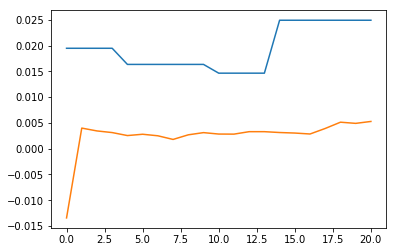

train days: 20 - 79
Run:  100/0.95/3/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.9 %  	 avg: -1.3 % 	 time: 0.82s
gen 2 	 max: 1.9 %  	 avg: 0.4 % 	 time: 0.8s
gen 3 	 max: 1.9 %  	 avg: 0.4 % 	 time: 0.78s
gen 4 	 max: 1.9 %  	 avg: 0.5 % 	 time: 0.79s
gen 5 	 max: 1.9 %  	 avg: 0.5 % 	 time: 0.77s
gen 6 	 max: 1.9 %  	 avg: 0.5 % 	 time: 0.82s
gen 7 	 max: 1.9 %  	 avg: 0.7 % 	 time: 0.78s
gen 8 	 max: 1.9 %  	 avg: 0.8 % 	 time: 0.81s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  6.37s
Max achieved at gen:  1
Stopping criteria in gen: 8


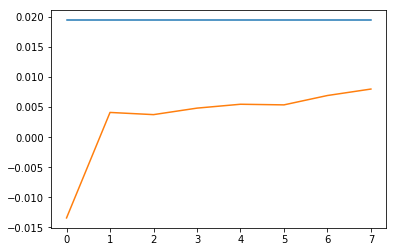

train days: 20 - 79
Run:  100/0.95/20/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.9 %  	 avg: -1.3 % 	 time: 0.92s
gen 2 	 max: 1.9 %  	 avg: -0.2 % 	 time: 0.87s
gen 3 	 max: 2.5 %  	 avg: -0.1 % 	 time: 0.84s
gen 4 	 max: 2.1 %  	 avg: 0.0 % 	 time: 0.84s
gen 5 	 max: 2.1 %  	 avg: 0.1 % 	 time: 0.89s
gen 6 	 max: 1.9 %  	 avg: 0.2 % 	 time: 0.83s
gen 7 	 max: 2.4 %  	 avg: -0.1 % 	 time: 0.86s
gen 8 	 max: 2.4 %  	 avg: 0.1 % 	 time: 0.83s
gen 9 	 max: 2.4 %  	 avg: 0.3 % 	 time: 0.85s
gen 10 	 max: 2.8 %  	 avg: 0.0 % 	 time: 0.84s
gen 11 	 max: 3.1 %  	 avg: 0.4 % 	 time: 0.85s
gen 12 	 max: 2.9 %  	 avg: 0.4 % 	 time: 0.84s
gen 13 	 max: 2.9 %  	 avg: 0.4 % 	 time: 0.84s
gen 14 	 max: 2.9 %  	 avg: 0.4 % 	 time: 0.83s
gen 15 	 max: 2.9 %  	 avg: 0.2 % 	 time: 0.84s
gen 16 	 max: 2.9 %  	 avg: 0.2 % 	 time: 0.83s
gen 17 	 max: 3.6 %  	 avg: 0.4 % 	 time: 0.84s
gen 18 	 max: 3.6 %  	 avg: 0.2 % 	 time: 1.04s
gen 19 	 max: 3.6 %  	 avg: 0.4 % 	 time: 0.84s
gen 20 	 max: 

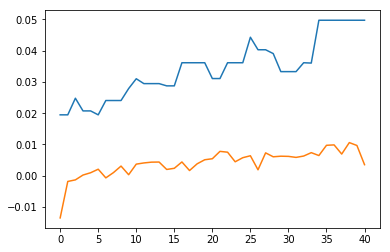

train days: 20 - 79
Run:  100/0.95/20/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.9 %  	 avg: -1.3 % 	 time: 0.87s
gen 2 	 max: 1.9 %  	 avg: -0.0 % 	 time: 0.83s
gen 3 	 max: 2.4 %  	 avg: 0.2 % 	 time: 0.82s
gen 4 	 max: 2.4 %  	 avg: 0.0 % 	 time: 0.81s
gen 5 	 max: 1.9 %  	 avg: 0.1 % 	 time: 0.83s
gen 6 	 max: 2.4 %  	 avg: 0.4 % 	 time: 0.84s
gen 7 	 max: 2.4 %  	 avg: 0.3 % 	 time: 0.83s
gen 8 	 max: 2.4 %  	 avg: -0.0 % 	 time: 0.88s
gen 9 	 max: 2.7 %  	 avg: 0.7 % 	 time: 0.85s
gen 10 	 max: 2.6 %  	 avg: 0.6 % 	 time: 0.81s
gen 11 	 max: 3.1 %  	 avg: 0.3 % 	 time: 0.83s
gen 12 	 max: 3.1 %  	 avg: 0.5 % 	 time: 0.83s
gen 13 	 max: 3.1 %  	 avg: 0.3 % 	 time: 0.82s
gen 14 	 max: 3.0 %  	 avg: 0.5 % 	 time: 0.81s
gen 15 	 max: 3.0 %  	 avg: 0.4 % 	 time: 0.85s
gen 16 	 max: 3.0 %  	 avg: 0.7 % 	 time: 0.83s
gen 17 	 max: 2.6 %  	 avg: 0.6 % 	 time: 0.83s
gen 18 	 max: 3.0 %  	 avg: 0.4 % 	 time: 0.85s
gen 19 	 max: 3.0 %  	 avg: 0.7 % 	 time: 0.87s
gen 20 	 max: 

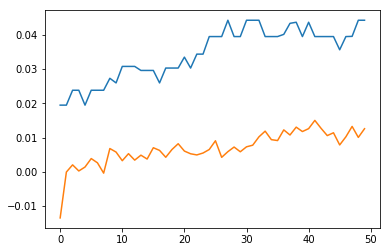

train days: 20 - 79
Run:  500/0.8/3/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.1 %  	 avg: -0.0 % 	 time: 4.02s
gen 2 	 max: 2.7 %  	 avg: 0.7 % 	 time: 4.06s
gen 3 	 max: 2.7 %  	 avg: 0.7 % 	 time: 4.13s
gen 4 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.12s
gen 5 	 max: 2.7 %  	 avg: 0.7 % 	 time: 4.11s
gen 6 	 max: 2.7 %  	 avg: 0.7 % 	 time: 4.06s
gen 7 	 max: 2.8 %  	 avg: 0.7 % 	 time: 4.08s
gen 8 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.09s
gen 9 	 max: 3.3 %  	 avg: 0.8 % 	 time: 4.14s
gen 10 	 max: 3.3 %  	 avg: 0.9 % 	 time: 4.12s
gen 11 	 max: 3.3 %  	 avg: 1.0 % 	 time: 4.08s
gen 12 	 max: 3.3 %  	 avg: 0.9 % 	 time: 4.1s
gen 13 	 max: 3.4 %  	 avg: 0.9 % 	 time: 4.65s
gen 14 	 max: 3.4 %  	 avg: 0.9 % 	 time: 4.32s
gen 15 	 max: 3.4 %  	 avg: 0.9 % 	 time: 4.45s
gen 16 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.39s
gen 17 	 max: 3.4 %  	 avg: 1.1 % 	 time: 4.12s
gen 18 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.11s
gen 19 	 max: 3.4 %  	 avg: 0.9 % 	 time: 4.09s
gen 20 	 max: 3.4 % 

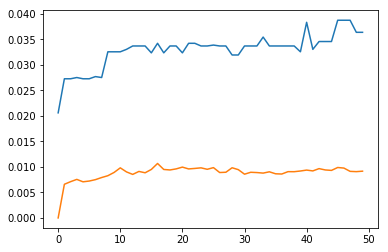

train days: 20 - 79
Run:  500/0.8/3/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.1 %  	 avg: -0.0 % 	 time: 4.08s
gen 2 	 max: 2.8 %  	 avg: 0.7 % 	 time: 4.14s
gen 3 	 max: 2.8 %  	 avg: 0.7 % 	 time: 4.15s
gen 4 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.2s
gen 5 	 max: 2.8 %  	 avg: 0.9 % 	 time: 4.22s
gen 6 	 max: 3.0 %  	 avg: 0.9 % 	 time: 4.29s
gen 7 	 max: 3.0 %  	 avg: 1.0 % 	 time: 8.27s
gen 8 	 max: 3.2 %  	 avg: 1.1 % 	 time: 4.38s
gen 9 	 max: 3.4 %  	 avg: 1.2 % 	 time: 4.71s
gen 10 	 max: 3.4 %  	 avg: 1.2 % 	 time: 5.64s
gen 11 	 max: 3.4 %  	 avg: 1.3 % 	 time: 4.57s
gen 12 	 max: 3.3 %  	 avg: 1.3 % 	 time: 4.38s
gen 13 	 max: 3.3 %  	 avg: 1.4 % 	 time: 5.21s
gen 14 	 max: 3.2 %  	 avg: 1.3 % 	 time: 4.25s
gen 15 	 max: 3.4 %  	 avg: 1.4 % 	 time: 10.25s
gen 16 	 max: 3.4 %  	 avg: 1.4 % 	 time: 5.03s
gen 17 	 max: 3.5 %  	 avg: 1.4 % 	 time: 4.24s
gen 18 	 max: 3.5 %  	 avg: 1.4 % 	 time: 4.22s
gen 19 	 max: 3.5 %  	 avg: 1.4 % 	 time: 4.26s
gen 20 	 max: 4.0 

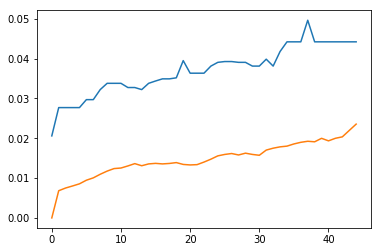

train days: 20 - 79
Run:  500/0.8/20/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.1 %  	 avg: -0.0 % 	 time: 4.18s
gen 2 	 max: 2.8 %  	 avg: 0.2 % 	 time: 4.31s
gen 3 	 max: 2.7 %  	 avg: 0.2 % 	 time: 4.28s
gen 4 	 max: 2.7 %  	 avg: 0.2 % 	 time: 4.33s
gen 5 	 max: 2.8 %  	 avg: 0.2 % 	 time: 4.26s
gen 6 	 max: 2.8 %  	 avg: 0.3 % 	 time: 5.58s
gen 7 	 max: 2.8 %  	 avg: 0.2 % 	 time: 5.26s
gen 8 	 max: 2.9 %  	 avg: 0.2 % 	 time: 5.89s
gen 9 	 max: 2.9 %  	 avg: 0.2 % 	 time: 5.21s
gen 10 	 max: 3.3 %  	 avg: 0.2 % 	 time: 6.14s
gen 11 	 max: 3.3 %  	 avg: 0.2 % 	 time: 4.45s
gen 12 	 max: 3.5 %  	 avg: 0.2 % 	 time: 4.68s
gen 13 	 max: 2.5 %  	 avg: 0.2 % 	 time: 4.61s
gen 14 	 max: 3.9 %  	 avg: 0.2 % 	 time: 4.26s
gen 15 	 max: 2.9 %  	 avg: 0.2 % 	 time: 4.3s
gen 16 	 max: 3.1 %  	 avg: 0.2 % 	 time: 4.25s
gen 17 	 max: 3.1 %  	 avg: 0.2 % 	 time: 4.23s
gen 18 	 max: 3.2 %  	 avg: 0.2 % 	 time: 4.2s
gen 19 	 max: 3.3 %  	 avg: 0.2 % 	 time: 4.23s
gen 20 	 max: 3.4 % 

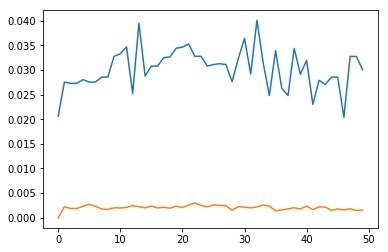

train days: 20 - 79
Run:  500/0.8/20/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.1 %  	 avg: -0.0 % 	 time: 4.41s
gen 2 	 max: 2.8 %  	 avg: 0.2 % 	 time: 4.42s
gen 3 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.4s
gen 4 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.42s
gen 5 	 max: 4.1 %  	 avg: 0.3 % 	 time: 4.2s
gen 6 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.3s
gen 7 	 max: 3.2 %  	 avg: 0.3 % 	 time: 4.25s
gen 8 	 max: 3.5 %  	 avg: 0.2 % 	 time: 4.37s
gen 9 	 max: 3.5 %  	 avg: 0.3 % 	 time: 4.23s
gen 10 	 max: 3.6 %  	 avg: 0.3 % 	 time: 4.23s
gen 11 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.22s
gen 12 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.23s
gen 13 	 max: 3.8 %  	 avg: 0.3 % 	 time: 4.24s
gen 14 	 max: 4.4 %  	 avg: 0.4 % 	 time: 4.45s
gen 15 	 max: 4.4 %  	 avg: 0.2 % 	 time: 5.37s
gen 16 	 max: 4.4 %  	 avg: 0.3 % 	 time: 6.27s
gen 17 	 max: 4.4 %  	 avg: 0.2 % 	 time: 6.08s
gen 18 	 max: 4.0 %  	 avg: 0.4 % 	 time: 4.84s
gen 19 	 max: 4.4 %  	 avg: 0.3 % 	 time: 4.3s
gen 20 	 max: 4.4 %  

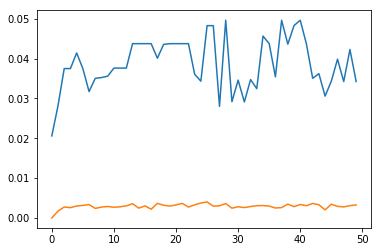

train days: 20 - 79
Run:  500/0.95/3/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.3 %  	 avg: -1.1 % 	 time: 4.47s
gen 2 	 max: 2.4 %  	 avg: 0.7 % 	 time: 5.31s
gen 3 	 max: 2.3 %  	 avg: 0.7 % 	 time: 4.2s
gen 4 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.22s
gen 5 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.17s
gen 6 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.2s
gen 7 	 max: 2.8 %  	 avg: 0.8 % 	 time: 4.6s
gen 8 	 max: 3.1 %  	 avg: 0.9 % 	 time: 4.81s
gen 9 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.47s
gen 10 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.59s
gen 11 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.3s
gen 12 	 max: 3.2 %  	 avg: 1.0 % 	 time: 4.28s
gen 13 	 max: 3.2 %  	 avg: 1.0 % 	 time: 4.25s
gen 14 	 max: 3.2 %  	 avg: 1.0 % 	 time: 4.27s
gen 15 	 max: 3.2 %  	 avg: 1.1 % 	 time: 4.44s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  66.6s
Max achieved at gen:  9
Stopping criteria in gen: 15


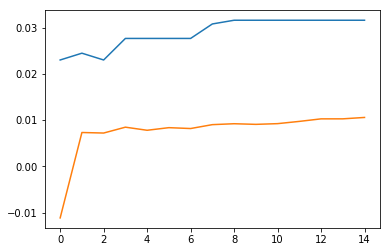

train days: 20 - 79
Run:  500/0.95/3/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.3 %  	 avg: -1.1 % 	 time: 4.61s
gen 2 	 max: 2.5 %  	 avg: 0.7 % 	 time: 4.34s
gen 3 	 max: 3.1 %  	 avg: 0.9 % 	 time: 4.34s
gen 4 	 max: 3.1 %  	 avg: 0.9 % 	 time: 5.04s
gen 5 	 max: 3.1 %  	 avg: 1.0 % 	 time: 7.96s
gen 6 	 max: 3.1 %  	 avg: 1.2 % 	 time: 4.53s
gen 7 	 max: 3.5 %  	 avg: 1.2 % 	 time: 4.35s
gen 8 	 max: 3.5 %  	 avg: 1.3 % 	 time: 4.43s
gen 9 	 max: 3.3 %  	 avg: 1.4 % 	 time: 4.23s
gen 10 	 max: 3.3 %  	 avg: 1.5 % 	 time: 4.31s
gen 11 	 max: 3.3 %  	 avg: 1.5 % 	 time: 4.42s
gen 12 	 max: 3.7 %  	 avg: 1.6 % 	 time: 7.42s
gen 13 	 max: 3.7 %  	 avg: 1.8 % 	 time: 6.56s
gen 14 	 max: 3.7 %  	 avg: 1.7 % 	 time: 6.11s
gen 15 	 max: 3.7 %  	 avg: 1.8 % 	 time: 5.73s
gen 16 	 max: 3.7 %  	 avg: 1.8 % 	 time: 6.97s
gen 17 	 max: 3.7 %  	 avg: 2.0 % 	 time: 6.84s
gen 18 	 max: 3.7 %  	 avg: 2.0 % 	 time: 7.44s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  99.

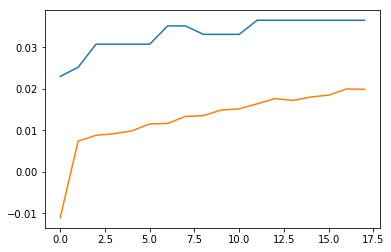

train days: 20 - 79
Run:  500/0.95/20/7 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.3 %  	 avg: -1.1 % 	 time: 10.75s
gen 2 	 max: 3.5 %  	 avg: -0.0 % 	 time: 12.77s
gen 3 	 max: 4.0 %  	 avg: 0.1 % 	 time: 6.57s
gen 4 	 max: 3.2 %  	 avg: 0.3 % 	 time: 5.81s
gen 5 	 max: 3.3 %  	 avg: 0.1 % 	 time: 5.96s
gen 6 	 max: 3.3 %  	 avg: 0.3 % 	 time: 5.94s
gen 7 	 max: 3.6 %  	 avg: 0.3 % 	 time: 5.96s
gen 8 	 max: 4.3 %  	 avg: 0.2 % 	 time: 5.97s
gen 9 	 max: 4.0 %  	 avg: 0.4 % 	 time: 6.13s
gen 10 	 max: 4.0 %  	 avg: 0.5 % 	 time: 6.88s
gen 11 	 max: 4.0 %  	 avg: 0.5 % 	 time: 10.03s
gen 12 	 max: 4.0 %  	 avg: 0.5 % 	 time: 7.06s
gen 13 	 max: 4.5 %  	 avg: 0.5 % 	 time: 5.94s
gen 14 	 max: 4.6 %  	 avg: 0.5 % 	 time: 6.07s
gen 15 	 max: 4.6 %  	 avg: 0.5 % 	 time: 6.03s
gen 16 	 max: 5.0 %  	 avg: 0.6 % 	 time: 6.49s
gen 17 	 max: 5.0 %  	 avg: 0.7 % 	 time: 6.68s
gen 18 	 max: 4.1 %  	 avg: 0.6 % 	 time: 7.44s
gen 19 	 max: 4.1 %  	 avg: 0.6 % 	 time: 6.28s
gen 20 	 max:

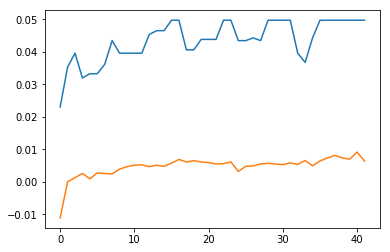

train days: 20 - 79
Run:  500/0.95/20/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.3 %  	 avg: -1.1 % 	 time: 6.88s
gen 2 	 max: 3.1 %  	 avg: 0.2 % 	 time: 6.16s
gen 3 	 max: 3.5 %  	 avg: 0.4 % 	 time: 7.53s
gen 4 	 max: 3.8 %  	 avg: 0.4 % 	 time: 6.77s
gen 5 	 max: 3.8 %  	 avg: 0.4 % 	 time: 6.88s
gen 6 	 max: 3.6 %  	 avg: 0.6 % 	 time: 10.29s
gen 7 	 max: 4.2 %  	 avg: 0.7 % 	 time: 7.19s
gen 8 	 max: 4.2 %  	 avg: 0.7 % 	 time: 6.27s
gen 9 	 max: 4.2 %  	 avg: 0.7 % 	 time: 7.15s
gen 10 	 max: 4.6 %  	 avg: 0.7 % 	 time: 6.04s
gen 11 	 max: 4.6 %  	 avg: 0.7 % 	 time: 6.03s
gen 12 	 max: 4.6 %  	 avg: 0.8 % 	 time: 6.13s
gen 13 	 max: 4.6 %  	 avg: 0.9 % 	 time: 6.15s
gen 14 	 max: 4.4 %  	 avg: 0.8 % 	 time: 6.32s
gen 15 	 max: 4.6 %  	 avg: 0.9 % 	 time: 6.79s
gen 16 	 max: 4.6 %  	 avg: 1.0 % 	 time: 6.13s
gen 17 	 max: 4.4 %  	 avg: 1.0 % 	 time: 6.12s
gen 18 	 max: 4.4 %  	 avg: 1.1 % 	 time: 6.2s
gen 19 	 max: 4.4 %  	 avg: 0.9 % 	 time: 6.1s
gen 20 	 max: 4.6

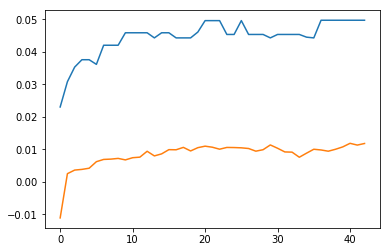

In [32]:
#get a feel for best params for exploration vs exploitation tradeoff
run_names = []
run_curves = []
run_converge = []
run_best = []
run_generations = []
run_time = []
run_strat = []
run_5strat = []
run_5ret = []

for t in n_traders_opt:
    n_traders = t
    for r in irrelevant_opt:
        irrelevant = r
        for m in Mutation_opt:
            Mutation = m
            for w in weight_exponent_opt:
                weight_exponent = w 
                      
                
                Train(n_traders = t, 
                      irrelevant = r,
                      Mutation = m,  
                      weight_exponent = w, 
                      start_day=start_day, 
                      end_day=end_day, 
                      stopper=stopper)

                #get run data                
                run_names.append(run)
                run_curves.append(max_return)
                run_converge.append(max_return[-1])
                run_best.append(max(max_return))
                run_generations.append(len(max_return)-stopper)
                run_time.append(secs)
                run_strat.append(str(top50['strategy'].iloc[0]))
                
                #do i need this?
                strats5 = []
                results5 = []
                for i in range(5):
                    strats5.append(top50['strategy'].iloc[i])
                    results5.append(top50['return'].iloc[i])
                
                run_5strat.append(strats5)
                run_5ret.append(results5)

all_runs = pd.DataFrame()
all_runs['Run']=run_names
all_runs['Converge']=run_converge
all_runs['Best']=run_best
all_runs['Gens']=run_generations
all_runs['Time']=run_time
all_runs['Top_Strat']=run_strat
all_runs['Curve']=run_curves
all_runs['T5strat']=run_5strat
all_runs['T5return']=run_5ret



               Run  Converge      Best  Gens    Time
0      100/0.8/3/7  0.021314  0.021314     5     9.7
1     100/0.8/3/20  0.014590  0.014590     2    6.98
2     100/0.8/20/7  0.023829  0.035925    43   41.95
3    100/0.8/20/20  0.034848  0.049671    43   41.64
4     100/0.95/3/7  0.024908  0.024908    14   16.82
5    100/0.95/3/20  0.019470  0.019470     1    6.37
6    100/0.95/20/7  0.049671  0.049671    34   35.15
7   100/0.95/20/20  0.044243  0.044243    43   42.12
8      500/0.8/3/7  0.036399  0.038768    43  227.33
9     500/0.8/3/20  0.044243  0.049671    38  216.61
10    500/0.8/20/7  0.030057  0.040074    43  225.32
11   500/0.8/20/20  0.034261  0.049671    43  228.88
12    500/0.95/3/7  0.031571  0.031571     8    66.6
13   500/0.95/3/20  0.036551  0.036551    11   99.68
14   500/0.95/20/7  0.049671  0.049671    35  296.23
15  500/0.95/20/20  0.049671  0.049671    36  278.08
100/0.8/3/7
9.7
5
0.0213135764334
0.0213135764334
[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0 

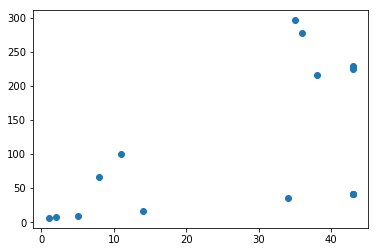

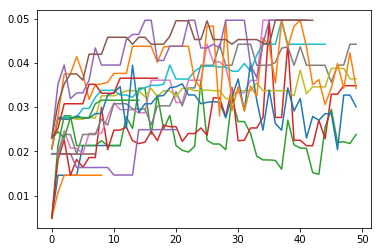

In [33]:
#did we arrive at the same place?
print(all_runs.iloc[:,0:5])

for i in range(all_runs.shape[0]):
    print(str(all_runs.Run[i]))
    print(str(all_runs.Time[i]))
    print(str(all_runs.Gens[i]))
    print(str(all_runs.Converge[i]))
    print(str(all_runs.Best[i]))
    print(str(all_runs.Top_Strat[i]),'\n\n')
    
#in how many seconds?
#plt.hist(list(all_runs.Time))
plt.scatter(all_runs.Gens, all_runs.Time)
plt.show()
for i in range(all_runs.shape[0]):
    plt.plot(all_runs.Curve[i])
plt.show()

# Train and test

train days: 20 - 79
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.0 %  	 avg: -0.3 % 	 time: 4.1s
gen 2 	 max: 3.4 %  	 avg: 0.5 % 	 time: 4.04s
gen 3 	 max: 3.8 %  	 avg: 0.4 % 	 time: 4.04s
gen 4 	 max: 3.4 %  	 avg: 0.6 % 	 time: 4.05s
gen 5 	 max: 3.8 %  	 avg: 0.7 % 	 time: 4.02s
gen 6 	 max: 4.0 %  	 avg: 0.7 % 	 time: 4.07s
gen 7 	 max: 4.0 %  	 avg: 0.9 % 	 time: 4.11s
gen 8 	 max: 4.4 %  	 avg: 1.0 % 	 time: 4.03s
gen 9 	 max: 4.4 %  	 avg: 1.0 % 	 time: 4.04s
gen 10 	 max: 4.4 %  	 avg: 1.1 % 	 time: 4.08s
gen 11 	 max: 5.0 %  	 avg: 1.1 % 	 time: 4.08s
gen 12 	 max: 5.0 %  	 avg: 1.1 % 	 time: 4.06s
gen 13 	 max: 5.0 %  	 avg: 1.2 % 	 time: 4.05s
gen 14 	 max: 5.0 %  	 avg: 1.2 % 	 time: 4.08s
gen 15 	 max: 5.0 %  	 avg: 1.4 % 	 time: 4.09s
gen 16 	 max: 5.0 %  	 avg: 1.5 % 	 time: 4.08s
gen 17 	 max: 5.0 %  	 avg: 1.4 % 	 time: 4.25s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  69.28s
Max achieved at gen:  11
Stopping criteria in

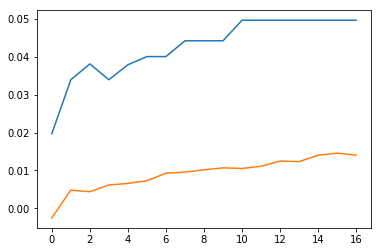

test days: 80 - 139
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       5.0 %  	       1.6 %	     26 	 


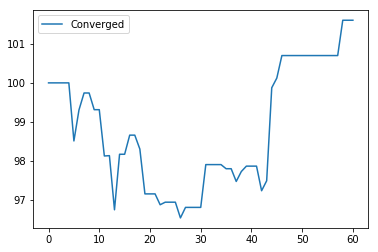

Converged 	decision vars: 3 	return 1.6
- day chg in USO
+ FXECYB corr
+ BNDFXY corr




In [41]:
##Variables selected from trials
n_traders = 500
irrelevant = .90
Mutation = 10
weight_exponent = 20

stopper = 7
max_generations = 50

trainperiod = 60
testperiod = 60  
start_day = 20  #do not start before this day because previous month variables do not exist <20
end_day = start_day + trainperiod -1
test_start_day = end_day+1
test_end_day = test_start_day + testperiod-1
spread = 0.0000001
seed = 33
random.seed(seed)

Train(n_traders=n_traders, 
      Mutation=Mutation, 
      irrelevant=irrelevant, 
      weight_exponent=weight_exponent, 
      start_day=start_day, 
      end_day=end_day, 
      stopper=stopper)

Test(test_start_day, test_end_day)

34 trials 
Training period: 60 trading days
Testing period: 60 trading days

Trial 1.0 
Training days: 140 - 199 
Testing days: 200 - 259 

train days: 140 - 199
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 9.7 %  	 avg: 0.3 % 	 time: 4.27s
gen 2 	 max: 10.1 %  	 avg: 2.6 % 	 time: 4.73s
gen 3 	 max: 10.8 %  	 avg: 4.0 % 	 time: 5.49s
gen 4 	 max: 12.0 %  	 avg: 4.4 % 	 time: 8.92s
gen 5 	 max: 12.0 %  	 avg: 5.0 % 	 time: 5.55s
gen 6 	 max: 12.0 %  	 avg: 5.6 % 	 time: 4.97s
gen 7 	 max: 12.0 %  	 avg: 5.6 % 	 time: 4.68s
gen 8 	 max: 12.0 %  	 avg: 5.8 % 	 time: 4.92s
gen 9 	 max: 12.0 %  	 avg: 6.4 % 	 time: 4.76s
gen 10 	 max: 12.0 %  	 avg: 6.2 % 	 time: 4.95s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  53.26s
Max achieved at gen:  4
Stopping criteria in gen: 10


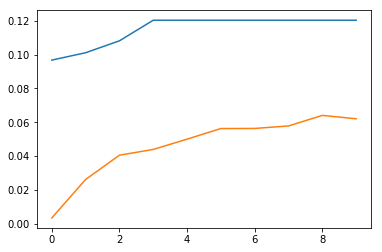

test days: 200 - 259
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       12.0 %  	       -5.6 %	     51 	 


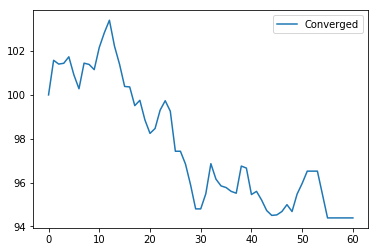

Converged 	decision vars: 3 	return -5.6
+ mo chg in SPY
+ SPYFXB corr
+ SPYCYB corr


Trial 2.0 
Training days: 200 - 259 
Testing days: 260 - 319 

train days: 200 - 259
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 4.3 %  	 avg: -0.2 % 	 time: 4.29s
gen 2 	 max: 4.3 %  	 avg: 0.8 % 	 time: 4.44s
gen 3 	 max: 4.5 %  	 avg: 0.9 % 	 time: 4.19s
gen 4 	 max: 4.5 %  	 avg: 0.9 % 	 time: 4.26s
gen 5 	 max: 4.5 %  	 avg: 1.1 % 	 time: 4.46s
gen 6 	 max: 5.0 %  	 avg: 1.1 % 	 time: 4.47s
gen 7 	 max: 4.8 %  	 avg: 1.2 % 	 time: 4.46s
gen 8 	 max: 4.9 %  	 avg: 1.4 % 	 time: 4.44s
gen 9 	 max: 4.9 %  	 avg: 1.4 % 	 time: 4.42s
gen 10 	 max: 5.3 %  	 avg: 1.5 % 	 time: 4.83s
gen 11 	 max: 5.0 %  	 avg: 1.8 % 	 time: 4.55s
gen 12 	 max: 5.0 %  	 avg: 1.7 % 	 time: 4.11s
gen 13 	 max: 5.5 %  	 avg: 1.6 % 	 time: 5.16s
gen 14 	 max: 5.5 %  	 avg: 1.7 % 	 time: 4.67s
gen 15 	 max: 5.5 %  	 avg: 2.0 % 	 time: 4.23s
gen 16 	 max: 5.5 %  	 avg: 2.1 % 	 time: 4.3s
gen 17 	 m

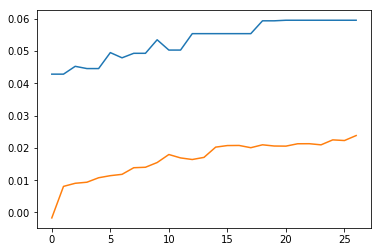

test days: 260 - 319
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       6.0 %  	       -1.7 %	     8 	 


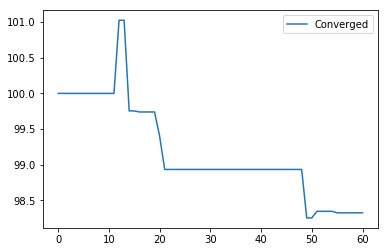

Converged 	decision vars: 4 	return -1.7
- day chg in GLD
+ FXESPY corr
- GLD autocor
- USO autocor


Trial 3.0 
Training days: 260 - 319 
Testing days: 320 - 379 

train days: 260 - 319
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 8.1 %  	 avg: 0.4 % 	 time: 4.5s
gen 2 	 max: 8.1 %  	 avg: 1.5 % 	 time: 4.21s
gen 3 	 max: 8.1 %  	 avg: 1.9 % 	 time: 4.19s
gen 4 	 max: 8.1 %  	 avg: 2.4 % 	 time: 4.32s
gen 5 	 max: 8.1 %  	 avg: 3.0 % 	 time: 4.49s
gen 6 	 max: 8.1 %  	 avg: 3.2 % 	 time: 4.59s
gen 7 	 max: 8.1 %  	 avg: 3.5 % 	 time: 4.46s
gen 8 	 max: 8.1 %  	 avg: 4.0 % 	 time: 4.37s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  35.16s
Max achieved at gen:  1
Stopping criteria in gen: 8


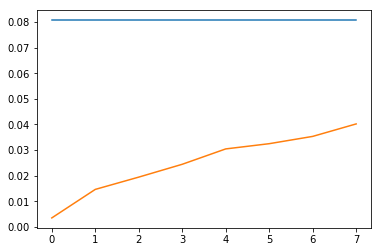

test days: 320 - 379
name	      dec vars	 train return	 test return	  trades	
Converged   	     1 	       8.1 %  	       -0.6 %	     59 	 


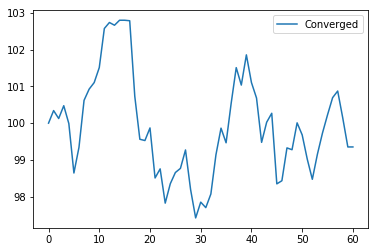

Converged 	decision vars: 1 	return -0.6
+ SPYCYB corr


Trial 4.0 
Training days: 320 - 379 
Testing days: 380 - 439 

train days: 320 - 379
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 6.5 %  	 avg: 0.0 % 	 time: 3.97s
gen 2 	 max: 6.5 %  	 avg: 1.2 % 	 time: 4.39s
gen 3 	 max: 8.4 %  	 avg: 1.5 % 	 time: 4.51s
gen 4 	 max: 8.4 %  	 avg: 2.0 % 	 time: 4.3s
gen 5 	 max: 8.5 %  	 avg: 2.4 % 	 time: 4.28s
gen 6 	 max: 8.5 %  	 avg: 3.2 % 	 time: 4.32s
gen 7 	 max: 8.5 %  	 avg: 3.5 % 	 time: 4.41s
gen 8 	 max: 9.7 %  	 avg: 3.8 % 	 time: 4.45s
gen 9 	 max: 8.8 %  	 avg: 4.0 % 	 time: 4.56s
gen 10 	 max: 9.8 %  	 avg: 4.2 % 	 time: 4.48s
gen 11 	 max: 9.8 %  	 avg: 4.3 % 	 time: 4.55s
gen 12 	 max: 9.8 %  	 avg: 4.4 % 	 time: 4.43s
gen 13 	 max: 9.8 %  	 avg: 4.6 % 	 time: 4.46s
gen 14 	 max: 9.8 %  	 avg: 4.5 % 	 time: 4.55s
gen 15 	 max: 9.8 %  	 avg: 4.7 % 	 time: 4.33s
gen 16 	 max: 10.2 %  	 avg: 4.8 % 	 time: 4.49s
gen 17 	 max: 10.2 %  	 avg: 5.0 % 	 tim

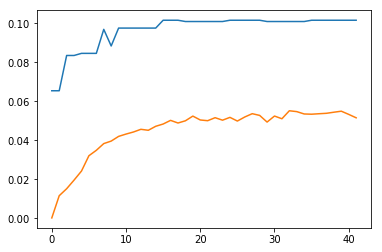

test days: 380 - 439
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       10.2 %  	       0.9 %	     6 	 


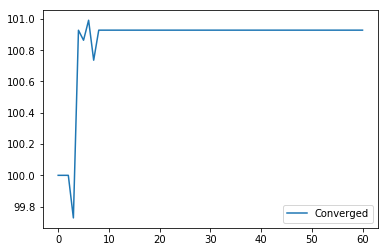

Converged 	decision vars: 4 	return 0.9
- wk chg in SPY
- mo chg in FXB
+ BNDFXY corr
- CYB autocor


Trial 5.0 
Training days: 380 - 439 
Testing days: 440 - 499 

train days: 380 - 439
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.6 %  	 avg: -0.2 % 	 time: 4.37s
gen 2 	 max: 3.9 %  	 avg: 0.6 % 	 time: 4.43s
gen 3 	 max: 5.5 %  	 avg: 0.9 % 	 time: 4.2s
gen 4 	 max: 5.2 %  	 avg: 1.1 % 	 time: 4.29s
gen 5 	 max: 5.8 %  	 avg: 1.1 % 	 time: 4.13s
gen 6 	 max: 5.8 %  	 avg: 1.0 % 	 time: 4.34s
gen 7 	 max: 6.5 %  	 avg: 1.2 % 	 time: 4.38s
gen 8 	 max: 6.5 %  	 avg: 1.4 % 	 time: 4.32s
gen 9 	 max: 6.5 %  	 avg: 1.6 % 	 time: 4.17s
gen 10 	 max: 6.5 %  	 avg: 1.9 % 	 time: 4.19s
gen 11 	 max: 6.5 %  	 avg: 2.0 % 	 time: 4.39s
gen 12 	 max: 6.5 %  	 avg: 2.1 % 	 time: 4.27s
gen 13 	 max: 6.5 %  	 avg: 2.4 % 	 time: 4.33s
gen 14 	 max: 6.5 %  	 avg: 2.5 % 	 time: 4.64s
gen 15 	 max: 6.5 %  	 avg: 2.7 % 	 time: 4.66s
¯\_(ツ)_/¯  - stopping because 7 gens conver

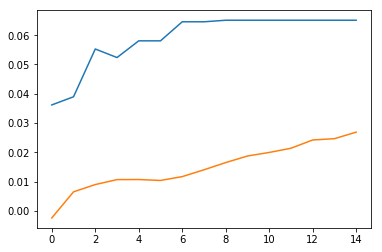

test days: 440 - 499
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       6.5 %  	       -1.6 %	     6 	 


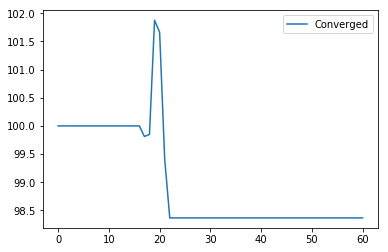

Converged 	decision vars: 4 	return -1.6
+ mo chg in GLD
+ GLDBND corr
+ GLDCYB corr
- USO autocor


Trial 6.0 
Training days: 440 - 499 
Testing days: 500 - 559 

train days: 440 - 499
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.4 %  	 avg: -0.1 % 	 time: 4.26s
gen 2 	 max: 5.4 %  	 avg: 1.1 % 	 time: 4.34s
gen 3 	 max: 6.0 %  	 avg: 1.6 % 	 time: 4.86s
gen 4 	 max: 6.1 %  	 avg: 1.8 % 	 time: 4.2s
gen 5 	 max: 6.1 %  	 avg: 1.9 % 	 time: 4.35s
gen 6 	 max: 6.9 %  	 avg: 2.1 % 	 time: 4.31s
gen 7 	 max: 6.9 %  	 avg: 2.1 % 	 time: 4.37s
gen 8 	 max: 7.0 %  	 avg: 2.3 % 	 time: 4.45s
gen 9 	 max: 7.0 %  	 avg: 2.6 % 	 time: 4.25s
gen 10 	 max: 7.1 %  	 avg: 2.7 % 	 time: 4.27s
gen 11 	 max: 7.1 %  	 avg: 2.8 % 	 time: 4.5s
gen 12 	 max: 7.0 %  	 avg: 2.8 % 	 time: 4.5s
gen 13 	 max: 6.1 %  	 avg: 2.7 % 	 time: 4.48s
gen 14 	 max: 6.1 %  	 avg: 2.7 % 	 time: 4.47s
gen 15 	 max: 6.1 %  	 avg: 2.5 % 	 time: 4.58s
gen 16 	 max: 6.1 %  	 avg: 2.7 % 	 time: 4.44

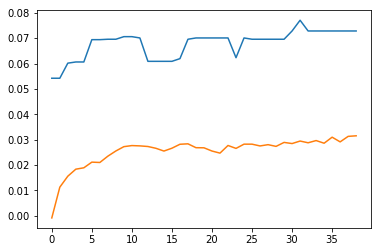

test days: 500 - 559
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       7.3 %  	       0.5 %	     6 	 


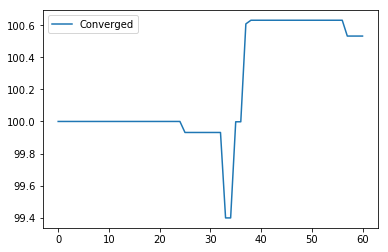

Converged 	decision vars: 2 	return 0.5
- day chg in BND
+ BND autocor


Trial 7.0 
Training days: 500 - 559 
Testing days: 560 - 619 

train days: 500 - 559
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 4.8 %  	 avg: 0.0 % 	 time: 4.19s
gen 2 	 max: 4.8 %  	 avg: 0.7 % 	 time: 4.25s
gen 3 	 max: 5.6 %  	 avg: 0.9 % 	 time: 4.52s
gen 4 	 max: 6.0 %  	 avg: 1.1 % 	 time: 4.42s
gen 5 	 max: 6.0 %  	 avg: 1.4 % 	 time: 4.47s
gen 6 	 max: 6.0 %  	 avg: 1.7 % 	 time: 4.63s
gen 7 	 max: 6.0 %  	 avg: 1.9 % 	 time: 4.46s
gen 8 	 max: 6.0 %  	 avg: 2.1 % 	 time: 4.25s
gen 9 	 max: 6.4 %  	 avg: 2.5 % 	 time: 4.29s
gen 10 	 max: 6.4 %  	 avg: 2.6 % 	 time: 4.39s
gen 11 	 max: 6.4 %  	 avg: 2.8 % 	 time: 4.51s
gen 12 	 max: 6.4 %  	 avg: 3.0 % 	 time: 4.64s
gen 13 	 max: 6.5 %  	 avg: 3.0 % 	 time: 4.39s
gen 14 	 max: 6.4 %  	 avg: 3.1 % 	 time: 4.81s
gen 15 	 max: 6.2 %  	 avg: 3.2 % 	 time: 4.45s
gen 16 	 max: 6.2 %  	 avg: 3.0 % 	 time: 4.27s
gen 17 	 max: 6.3 %  	 a

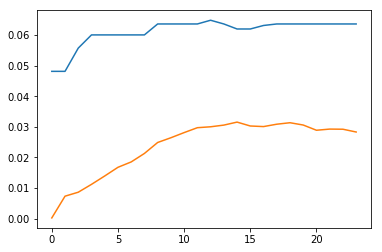

test days: 560 - 619
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       6.4 %  	       -5.0 %	     30 	 


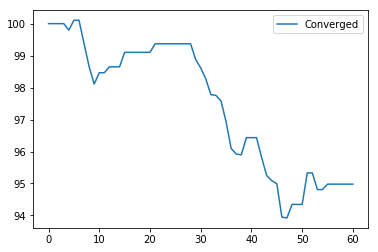

Converged 	decision vars: 2 	return -5.0
- day chg in FXE
- wk chg in USO


Trial 8.0 
Training days: 560 - 619 
Testing days: 620 - 679 

train days: 560 - 619
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.0 %  	 avg: -0.2 % 	 time: 4.01s
gen 2 	 max: 2.8 %  	 avg: 0.2 % 	 time: 4.29s
gen 3 	 max: 2.8 %  	 avg: 0.3 % 	 time: 4.22s
gen 4 	 max: 3.3 %  	 avg: 0.5 % 	 time: 4.21s
gen 5 	 max: 3.3 %  	 avg: 0.6 % 	 time: 4.25s
gen 6 	 max: 3.3 %  	 avg: 0.5 % 	 time: 4.35s
gen 7 	 max: 2.9 %  	 avg: 0.6 % 	 time: 4.43s
gen 8 	 max: 2.9 %  	 avg: 0.7 % 	 time: 4.36s
gen 9 	 max: 3.4 %  	 avg: 0.7 % 	 time: 4.2s
gen 10 	 max: 3.4 %  	 avg: 0.7 % 	 time: 4.28s
gen 11 	 max: 2.9 %  	 avg: 0.8 % 	 time: 4.39s
gen 12 	 max: 2.9 %  	 avg: 0.7 % 	 time: 4.34s
gen 13 	 max: 2.8 %  	 avg: 0.7 % 	 time: 4.13s
gen 14 	 max: 3.4 %  	 avg: 0.8 % 	 time: 4.27s
gen 15 	 max: 3.4 %  	 avg: 0.9 % 	 time: 4.64s
gen 16 	 max: 3.0 %  	 avg: 0.8 % 	 time: 4.45s
gen 17 	 max: 3.5 %  

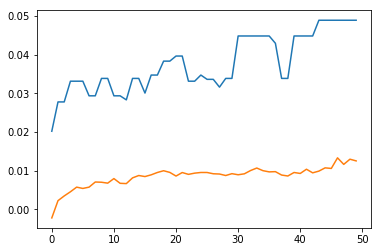

test days: 620 - 679
name	      dec vars	 train return	 test return	  trades	
Converged   	     5 	       4.9 %  	       0.1 %	     5 	 


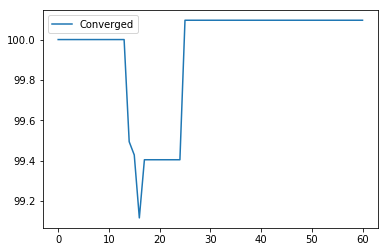

Converged 	decision vars: 5 	return 0.1
- wk chg in SPY
- mo chg in GLD
+ FXEFXB corr
- USOFXY corr
- USO autocor


Trial 9.0 
Training days: 620 - 679 
Testing days: 680 - 739 

train days: 620 - 679
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.8 %  	 avg: 0.1 % 	 time: 4.0s
gen 2 	 max: 5.6 %  	 avg: 1.2 % 	 time: 4.28s
gen 3 	 max: 5.7 %  	 avg: 1.4 % 	 time: 4.52s
gen 4 	 max: 5.7 %  	 avg: 1.6 % 	 time: 4.29s
gen 5 	 max: 5.7 %  	 avg: 1.7 % 	 time: 4.97s
gen 6 	 max: 5.7 %  	 avg: 1.7 % 	 time: 4.45s
gen 7 	 max: 5.7 %  	 avg: 1.9 % 	 time: 4.75s
gen 8 	 max: 5.9 %  	 avg: 1.9 % 	 time: 4.66s
gen 9 	 max: 6.0 %  	 avg: 2.1 % 	 time: 5.02s
gen 10 	 max: 6.0 %  	 avg: 2.4 % 	 time: 4.27s
gen 11 	 max: 5.8 %  	 avg: 2.3 % 	 time: 6.02s
gen 12 	 max: 5.8 %  	 avg: 2.4 % 	 time: 5.43s
gen 13 	 max: 6.6 %  	 avg: 2.7 % 	 time: 7.43s
gen 14 	 max: 6.6 %  	 avg: 2.9 % 	 time: 4.61s
gen 15 	 max: 6.6 %  	 avg: 3.0 % 	 time: 4.7s
gen 16 	 max: 6.6 %  	 avg: 2.9

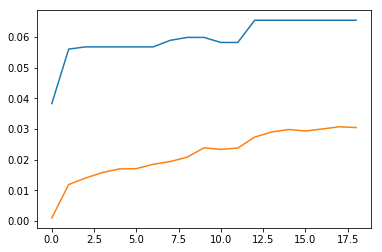

test days: 680 - 739
name	      dec vars	 train return	 test return	  trades	
Converged   	     1 	       6.6 %  	       0.8 %	     15 	 


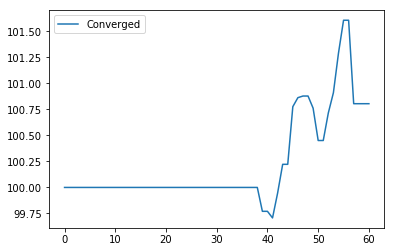

Converged 	decision vars: 1 	return 0.8
+ GLD autocor


Trial 10.0 
Training days: 680 - 739 
Testing days: 740 - 799 

train days: 680 - 739
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.2 %  	 avg: -0.1 % 	 time: 5.26s
gen 2 	 max: 3.4 %  	 avg: 0.5 % 	 time: 5.28s
gen 3 	 max: 3.4 %  	 avg: 0.6 % 	 time: 5.45s
gen 4 	 max: 3.9 %  	 avg: 0.7 % 	 time: 5.35s
gen 5 	 max: 4.6 %  	 avg: 0.8 % 	 time: 5.96s
gen 6 	 max: 4.6 %  	 avg: 1.0 % 	 time: 5.84s
gen 7 	 max: 4.6 %  	 avg: 1.1 % 	 time: 5.84s
gen 8 	 max: 4.9 %  	 avg: 1.2 % 	 time: 6.39s
gen 9 	 max: 4.9 %  	 avg: 1.2 % 	 time: 5.42s
gen 10 	 max: 4.9 %  	 avg: 1.3 % 	 time: 5.46s
gen 11 	 max: 4.9 %  	 avg: 1.5 % 	 time: 5.35s
gen 12 	 max: 4.9 %  	 avg: 1.6 % 	 time: 5.44s
gen 13 	 max: 4.9 %  	 avg: 1.8 % 	 time: 5.64s
gen 14 	 max: 4.9 %  	 avg: 1.8 % 	 time: 5.67s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  78.38s
Max achieved at gen:  8
Stopping criteria in gen: 14


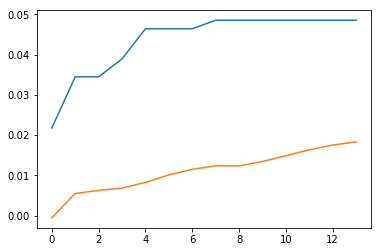

test days: 740 - 799
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       4.9 %  	       -2.8 %	     24 	 


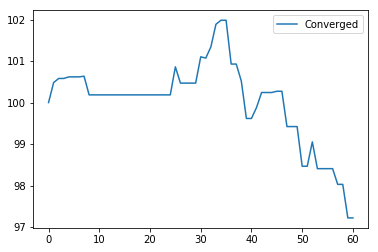

Converged 	decision vars: 3 	return -2.8
+ day chg in USO
+ GLDUSO corr
+ GLDFXY corr


Trial 11.0 
Training days: 740 - 799 
Testing days: 800 - 859 

train days: 740 - 799
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.7 %  	 avg: 0.0 % 	 time: 5.12s
gen 2 	 max: 4.2 %  	 avg: 0.8 % 	 time: 5.29s
gen 3 	 max: 4.5 %  	 avg: 1.0 % 	 time: 5.45s
gen 4 	 max: 4.5 %  	 avg: 0.9 % 	 time: 5.97s
gen 5 	 max: 4.3 %  	 avg: 1.2 % 	 time: 5.11s
gen 6 	 max: 4.3 %  	 avg: 1.1 % 	 time: 4.68s
gen 7 	 max: 5.3 %  	 avg: 1.2 % 	 time: 4.63s
gen 8 	 max: 5.3 %  	 avg: 1.3 % 	 time: 4.28s
gen 9 	 max: 5.3 %  	 avg: 1.4 % 	 time: 4.57s
gen 10 	 max: 5.3 %  	 avg: 1.5 % 	 time: 4.23s
gen 11 	 max: 5.3 %  	 avg: 1.6 % 	 time: 4.41s
gen 12 	 max: 5.3 %  	 avg: 1.6 % 	 time: 4.65s
gen 13 	 max: 5.3 %  	 avg: 1.7 % 	 time: 4.29s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  62.7s
Max achieved at gen:  7
Stopping criteria in gen: 13


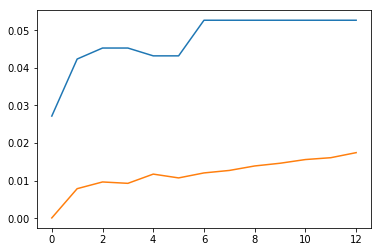

test days: 800 - 859
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       5.3 %  	       -0.4 %	     1 	 


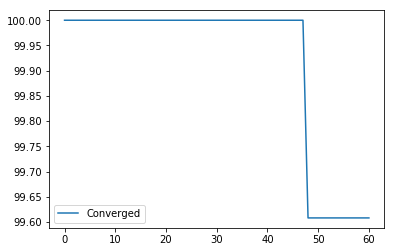

Converged 	decision vars: 2 	return -0.4
+ SPY autocor
- GLD autocor


Trial 12.0 
Training days: 800 - 859 
Testing days: 860 - 919 

train days: 800 - 859
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 4.2 %  	 avg: 0.1 % 	 time: 4.0s
gen 2 	 max: 4.4 %  	 avg: 0.7 % 	 time: 4.08s
gen 3 	 max: 4.2 %  	 avg: 0.8 % 	 time: 4.43s
gen 4 	 max: 4.5 %  	 avg: 0.9 % 	 time: 5.0s
gen 5 	 max: 4.5 %  	 avg: 1.1 % 	 time: 5.86s
gen 6 	 max: 4.5 %  	 avg: 1.3 % 	 time: 4.53s
gen 7 	 max: 4.5 %  	 avg: 1.3 % 	 time: 4.92s
gen 8 	 max: 4.9 %  	 avg: 1.5 % 	 time: 4.36s
gen 9 	 max: 4.9 %  	 avg: 1.6 % 	 time: 4.42s
gen 10 	 max: 4.9 %  	 avg: 1.6 % 	 time: 4.54s
gen 11 	 max: 4.9 %  	 avg: 1.6 % 	 time: 4.42s
gen 12 	 max: 5.4 %  	 avg: 1.6 % 	 time: 4.68s
gen 13 	 max: 5.4 %  	 avg: 1.8 % 	 time: 4.58s
gen 14 	 max: 5.4 %  	 avg: 1.9 % 	 time: 4.46s
gen 15 	 max: 5.4 %  	 avg: 1.8 % 	 time: 4.46s
gen 16 	 max: 5.4 %  	 avg: 1.7 % 	 time: 4.29s
gen 17 	 max: 5.4 %  	 avg:

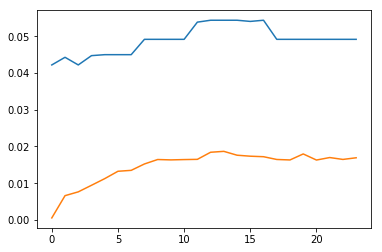

test days: 860 - 919
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       4.9 %  	       1.3 %	     3 	 


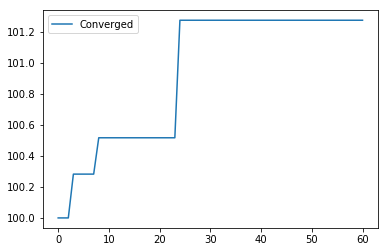

Converged 	decision vars: 3 	return 1.3
- day chg in FXE
+ mo chg in CYB
+ USOCYB corr


Trial 13.0 
Training days: 860 - 919 
Testing days: 920 - 979 

train days: 860 - 919
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 4.4 %  	 avg: 0.0 % 	 time: 4.1s
gen 2 	 max: 4.6 %  	 avg: 0.9 % 	 time: 4.43s
gen 3 	 max: 5.4 %  	 avg: 1.1 % 	 time: 4.42s
gen 4 	 max: 5.4 %  	 avg: 1.3 % 	 time: 5.24s
gen 5 	 max: 5.4 %  	 avg: 1.5 % 	 time: 4.26s
gen 6 	 max: 5.8 %  	 avg: 1.6 % 	 time: 4.63s
gen 7 	 max: 5.8 %  	 avg: 1.8 % 	 time: 4.78s
gen 8 	 max: 5.8 %  	 avg: 2.0 % 	 time: 4.43s
gen 9 	 max: 5.5 %  	 avg: 2.1 % 	 time: 4.51s
gen 10 	 max: 5.5 %  	 avg: 2.3 % 	 time: 4.47s
gen 11 	 max: 5.8 %  	 avg: 2.4 % 	 time: 4.66s
gen 12 	 max: 5.8 %  	 avg: 2.4 % 	 time: 4.3s
gen 13 	 max: 5.8 %  	 avg: 2.4 % 	 time: 4.31s
gen 14 	 max: 5.8 %  	 avg: 2.6 % 	 time: 4.31s
gen 15 	 max: 6.1 %  	 avg: 2.5 % 	 time: 4.61s
gen 16 	 max: 6.3 %  	 avg: 2.6 % 	 time: 4.53s
gen 17 	 

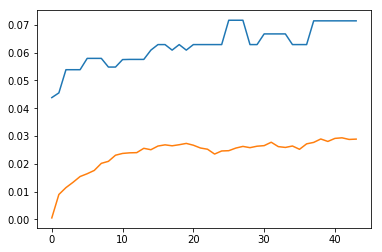

test days: 920 - 979
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       7.1 %  	       0.7 %	     5 	 


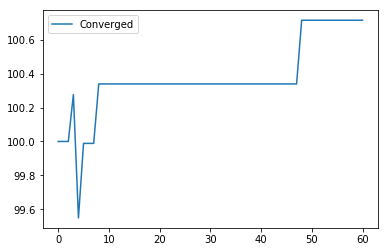

Converged 	decision vars: 4 	return 0.7
- day chg in BND
- wk chg in BND
+ GLDBND corr
+ BNDCYB corr


Trial 14.0 
Training days: 920 - 979 
Testing days: 980 - 1039 

train days: 920 - 979
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.2 %  	 avg: 0.2 % 	 time: 4.28s
gen 2 	 max: 5.2 %  	 avg: 0.9 % 	 time: 4.7s
gen 3 	 max: 5.2 %  	 avg: 1.2 % 	 time: 4.42s
gen 4 	 max: 5.2 %  	 avg: 1.5 % 	 time: 4.77s
gen 5 	 max: 5.2 %  	 avg: 1.7 % 	 time: 4.55s
gen 6 	 max: 5.2 %  	 avg: 1.8 % 	 time: 4.41s
gen 7 	 max: 5.8 %  	 avg: 1.9 % 	 time: 4.47s
gen 8 	 max: 5.8 %  	 avg: 2.1 % 	 time: 4.74s
gen 9 	 max: 5.8 %  	 avg: 2.1 % 	 time: 4.56s
gen 10 	 max: 5.8 %  	 avg: 2.1 % 	 time: 4.51s
gen 11 	 max: 5.8 %  	 avg: 2.2 % 	 time: 4.6s
gen 12 	 max: 5.8 %  	 avg: 2.3 % 	 time: 4.63s
gen 13 	 max: 5.8 %  	 avg: 2.3 % 	 time: 4.76s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  59.46s
Max achieved at gen:  7
Stopping criteria in gen: 13


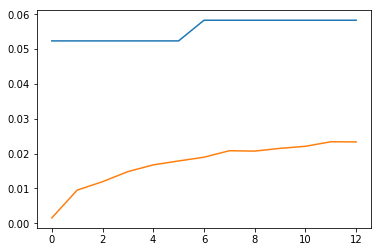

test days: 980 - 1039
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       5.8 %  	       2.2 %	     29 	 


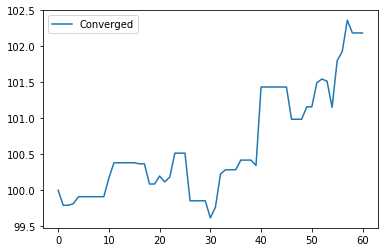

Converged 	decision vars: 2 	return 2.2
+ day chg in SPY
- FXY autocor


Trial 15.0 
Training days: 980 - 1039 
Testing days: 1040 - 1099 

train days: 980 - 1039
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.9 %  	 avg: 0.0 % 	 time: 4.4s
gen 2 	 max: 2.9 %  	 avg: 0.5 % 	 time: 4.79s
gen 3 	 max: 3.9 %  	 avg: 0.6 % 	 time: 4.45s
gen 4 	 max: 2.9 %  	 avg: 0.7 % 	 time: 4.56s
gen 5 	 max: 3.0 %  	 avg: 0.8 % 	 time: 4.33s
gen 6 	 max: 3.1 %  	 avg: 0.8 % 	 time: 4.57s
gen 7 	 max: 3.9 %  	 avg: 0.9 % 	 time: 4.51s
gen 8 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.24s
gen 9 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.41s
gen 10 	 max: 3.2 %  	 avg: 0.9 % 	 time: 4.73s
gen 11 	 max: 3.1 %  	 avg: 1.0 % 	 time: 4.43s
gen 12 	 max: 3.0 %  	 avg: 0.9 % 	 time: 4.32s
gen 13 	 max: 3.2 %  	 avg: 1.0 % 	 time: 4.67s
gen 14 	 max: 3.0 %  	 avg: 1.0 % 	 time: 4.43s
gen 15 	 max: 3.6 %  	 avg: 1.1 % 	 time: 4.61s
gen 16 	 max: 3.9 %  	 avg: 1.1 % 	 time: 4.48s
gen 17 	 max: 3.9 % 

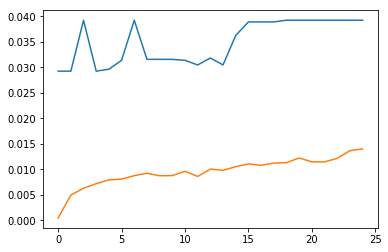

test days: 1040 - 1099
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       3.9 %  	       -0.2 %	     13 	 


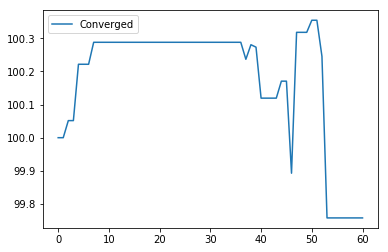

Converged 	decision vars: 4 	return -0.2
+ day chg in USO
+ GLDBND corr
+ USOFXB corr
- GLD autocor


Trial 16.0 
Training days: 1040 - 1099 
Testing days: 1100 - 1159 

train days: 1040 - 1099
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.3 %  	 avg: -0.0 % 	 time: 4.4s
gen 2 	 max: 3.3 %  	 avg: 0.5 % 	 time: 4.42s
gen 3 	 max: 3.3 %  	 avg: 0.5 % 	 time: 4.65s
gen 4 	 max: 3.3 %  	 avg: 0.5 % 	 time: 4.59s
gen 5 	 max: 3.3 %  	 avg: 0.6 % 	 time: 4.35s
gen 6 	 max: 3.3 %  	 avg: 0.6 % 	 time: 4.42s
gen 7 	 max: 3.3 %  	 avg: 0.7 % 	 time: 4.37s
gen 8 	 max: 3.3 %  	 avg: 0.7 % 	 time: 4.46s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  35.69s
Max achieved at gen:  1
Stopping criteria in gen: 8


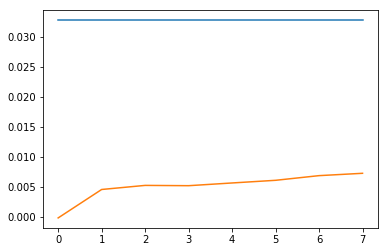

test days: 1100 - 1159
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       3.3 %  	       -0.1 %	     1 	 


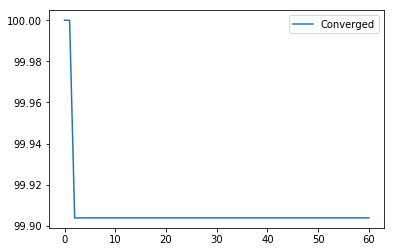

Converged 	decision vars: 3 	return -0.1
+ day chg in GLD
+ wk chg in GLD
- mo chg in CYB


Trial 17.0 
Training days: 1100 - 1159 
Testing days: 1160 - 1219 

train days: 1100 - 1159
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.0 %  	 avg: -0.1 % 	 time: 4.27s
gen 2 	 max: 1.0 %  	 avg: 0.1 % 	 time: 4.31s
gen 3 	 max: 1.0 %  	 avg: 0.1 % 	 time: 4.34s
gen 4 	 max: 1.0 %  	 avg: 0.1 % 	 time: 4.21s
gen 5 	 max: 1.0 %  	 avg: 0.1 % 	 time: 4.13s
gen 6 	 max: 1.0 %  	 avg: 0.2 % 	 time: 3.96s
gen 7 	 max: 1.0 %  	 avg: 0.1 % 	 time: 3.98s
gen 8 	 max: 1.0 %  	 avg: 0.1 % 	 time: 4.08s
gen 9 	 max: 1.1 %  	 avg: 0.2 % 	 time: 4.04s
gen 10 	 max: 1.1 %  	 avg: 0.2 % 	 time: 4.07s
gen 11 	 max: 1.1 %  	 avg: 0.2 % 	 time: 3.99s
gen 12 	 max: 1.0 %  	 avg: 0.2 % 	 time: 4.38s
gen 13 	 max: 1.0 %  	 avg: 0.2 % 	 time: 4.49s
gen 14 	 max: 1.1 %  	 avg: 0.2 % 	 time: 4.36s
gen 15 	 max: 1.2 %  	 avg: 0.2 % 	 time: 4.37s
gen 16 	 max: 1.0 %  	 avg: 0.2 % 	 time: 4.6

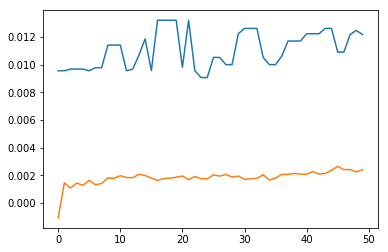

test days: 1160 - 1219
name	      dec vars	 train return	 test return	  trades	
Converged   	     5 	       1.2 %  	       -1.0 %	     18 	 


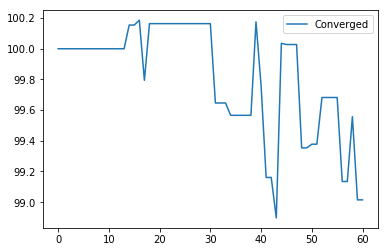

Converged 	decision vars: 5 	return -1.0
- day chg in USO
- mo chg in FXE
- SPYBND corr
+ USOFXB corr
+ FXBFXY corr


Trial 18.0 
Training days: 1160 - 1219 
Testing days: 1220 - 1279 

train days: 1160 - 1219
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.7 %  	 avg: -0.3 % 	 time: 4.0s
gen 2 	 max: 2.2 %  	 avg: 0.2 % 	 time: 4.44s
gen 3 	 max: 2.2 %  	 avg: 0.2 % 	 time: 4.29s
gen 4 	 max: 2.2 %  	 avg: 0.3 % 	 time: 4.33s
gen 5 	 max: 2.3 %  	 avg: 0.3 % 	 time: 4.03s
gen 6 	 max: 2.3 %  	 avg: 0.4 % 	 time: 4.03s
gen 7 	 max: 2.6 %  	 avg: 0.4 % 	 time: 4.14s
gen 8 	 max: 2.6 %  	 avg: 0.5 % 	 time: 4.19s
gen 9 	 max: 2.6 %  	 avg: 0.5 % 	 time: 4.15s
gen 10 	 max: 2.6 %  	 avg: 0.4 % 	 time: 4.01s
gen 11 	 max: 2.6 %  	 avg: 0.5 % 	 time: 4.29s
gen 12 	 max: 3.0 %  	 avg: 0.5 % 	 time: 4.1s
gen 13 	 max: 2.6 %  	 avg: 0.6 % 	 time: 4.05s
gen 14 	 max: 2.6 %  	 avg: 0.6 % 	 time: 4.09s
gen 15 	 max: 2.6 %  	 avg: 0.6 % 	 time: 4.1s
gen 16 	 max: 2.6 %  	

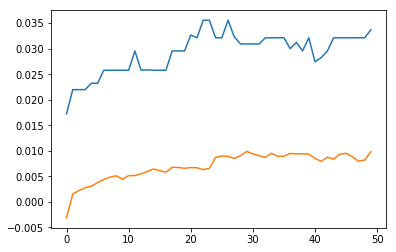

test days: 1220 - 1279
name	      dec vars	 train return	 test return	  trades	
Converged   	     8 	       3.4 %  	       -0.4 %	     3 	 


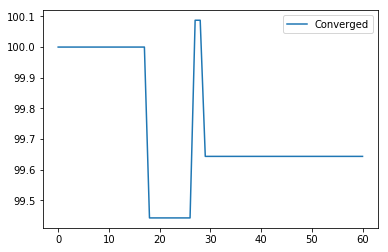

Converged 	decision vars: 8 	return -0.4
- day chg in FXE
- day chg in FXB
- wk chg in SPY
- wk chg in USO
- SPYFXY corr
+ GLDUSO corr
+ GLDFXB corr
- SPY autocor


Trial 19.0 
Training days: 1220 - 1279 
Testing days: 1280 - 1339 

train days: 1220 - 1279
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.9 %  	 avg: -0.4 % 	 time: 4.2s
gen 2 	 max: 3.1 %  	 avg: 0.5 % 	 time: 4.01s
gen 3 	 max: 3.2 %  	 avg: 0.6 % 	 time: 4.2s
gen 4 	 max: 3.1 %  	 avg: 0.7 % 	 time: 4.05s
gen 5 	 max: 3.4 %  	 avg: 0.6 % 	 time: 4.0s
gen 6 	 max: 3.0 %  	 avg: 0.7 % 	 time: 4.01s
gen 7 	 max: 3.0 %  	 avg: 0.8 % 	 time: 4.06s
gen 8 	 max: 3.3 %  	 avg: 0.8 % 	 time: 4.05s
gen 9 	 max: 3.9 %  	 avg: 0.8 % 	 time: 4.06s
gen 10 	 max: 3.3 %  	 avg: 0.8 % 	 time: 4.13s
gen 11 	 max: 3.9 %  	 avg: 0.8 % 	 time: 4.41s
gen 12 	 max: 3.9 %  	 avg: 0.9 % 	 time: 4.28s
gen 13 	 max: 3.9 %  	 avg: 0.8 % 	 time: 4.19s
gen 14 	 max: 4.0 %  	 avg: 1.1 % 	 time: 4.16s
gen 15 	 max: 4.0 %  	 

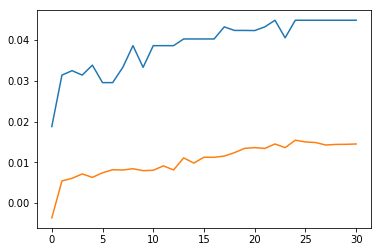

test days: 1280 - 1339
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       4.5 %  	       0.6 %	     9 	 


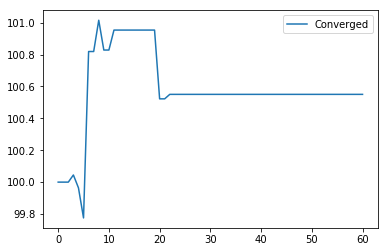

Converged 	decision vars: 2 	return 0.6
- day chg in BND
- mo chg in CYB


Trial 20.0 
Training days: 1280 - 1339 
Testing days: 1340 - 1399 

train days: 1280 - 1339
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.7 %  	 avg: -0.1 % 	 time: 4.7s
gen 2 	 max: 7.0 %  	 avg: 0.9 % 	 time: 4.88s
gen 3 	 max: 7.0 %  	 avg: 1.1 % 	 time: 4.17s
gen 4 	 max: 7.0 %  	 avg: 1.4 % 	 time: 4.49s
gen 5 	 max: 7.0 %  	 avg: 1.6 % 	 time: 4.51s
gen 6 	 max: 7.0 %  	 avg: 2.2 % 	 time: 5.32s
gen 7 	 max: 7.7 %  	 avg: 2.3 % 	 time: 4.43s
gen 8 	 max: 7.8 %  	 avg: 2.6 % 	 time: 4.59s
gen 9 	 max: 7.9 %  	 avg: 3.2 % 	 time: 4.39s
gen 10 	 max: 8.2 %  	 avg: 3.1 % 	 time: 4.51s
gen 11 	 max: 8.2 %  	 avg: 3.4 % 	 time: 4.78s
gen 12 	 max: 8.2 %  	 avg: 3.7 % 	 time: 4.98s
gen 13 	 max: 8.9 %  	 avg: 3.7 % 	 time: 4.85s
gen 14 	 max: 9.0 %  	 avg: 3.6 % 	 time: 4.51s
gen 15 	 max: 8.9 %  	 avg: 3.9 % 	 time: 4.78s
gen 16 	 max: 8.9 %  	 avg: 4.1 % 	 time: 4.45s
gen 17 	 max: 8

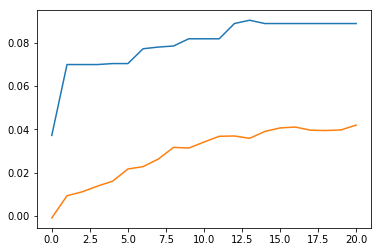

test days: 1340 - 1399
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       8.9 %  	       -1.5 %	     10 	 


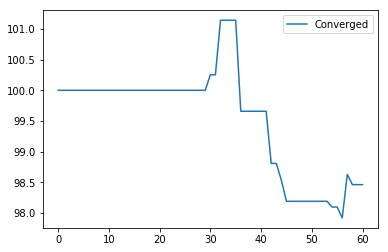

Converged 	decision vars: 4 	return -1.5
+ wk chg in BND
+ wk chg in CYB
- mo chg in SPY
- mo chg in USO


Trial 21.0 
Training days: 1340 - 1399 
Testing days: 1400 - 1459 

train days: 1340 - 1399
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 4.1 %  	 avg: -0.1 % 	 time: 4.26s
gen 2 	 max: 5.6 %  	 avg: 1.0 % 	 time: 4.27s
gen 3 	 max: 5.6 %  	 avg: 1.2 % 	 time: 4.28s
gen 4 	 max: 7.4 %  	 avg: 1.4 % 	 time: 4.22s
gen 5 	 max: 7.4 %  	 avg: 1.6 % 	 time: 4.24s
gen 6 	 max: 7.4 %  	 avg: 1.7 % 	 time: 4.35s
gen 7 	 max: 7.4 %  	 avg: 2.0 % 	 time: 4.35s
gen 8 	 max: 8.1 %  	 avg: 2.2 % 	 time: 4.26s
gen 9 	 max: 8.1 %  	 avg: 2.4 % 	 time: 4.28s
gen 10 	 max: 8.1 %  	 avg: 2.6 % 	 time: 4.32s
gen 11 	 max: 8.2 %  	 avg: 3.1 % 	 time: 4.37s
gen 12 	 max: 8.1 %  	 avg: 3.2 % 	 time: 4.34s
gen 13 	 max: 8.2 %  	 avg: 3.2 % 	 time: 4.37s
gen 14 	 max: 8.2 %  	 avg: 3.2 % 	 time: 4.28s
gen 15 	 max: 8.1 %  	 avg: 3.2 % 	 time: 4.38s
gen 16 	 max: 8.1 %  	 avg: 3.

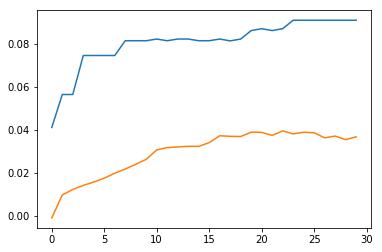

test days: 1400 - 1459
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       9.1 %  	       5.2 %	     21 	 


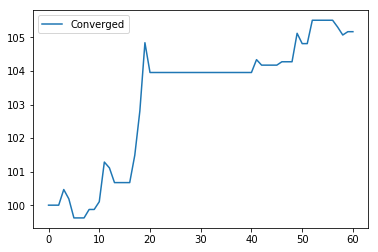

Converged 	decision vars: 4 	return 5.2
- day chg in CYB
+ SPYFXB corr
+ BNDFXY corr
+ USOFXB corr


Trial 22.0 
Training days: 1400 - 1459 
Testing days: 1460 - 1519 

train days: 1400 - 1459
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.1 %  	 avg: 0.1 % 	 time: 4.31s
gen 2 	 max: 6.9 %  	 avg: 1.2 % 	 time: 4.28s
gen 3 	 max: 7.2 %  	 avg: 1.7 % 	 time: 4.36s
gen 4 	 max: 7.2 %  	 avg: 2.1 % 	 time: 4.73s
gen 5 	 max: 7.2 %  	 avg: 2.5 % 	 time: 4.5s
gen 6 	 max: 7.2 %  	 avg: 2.7 % 	 time: 4.58s
gen 7 	 max: 7.2 %  	 avg: 3.0 % 	 time: 4.49s
gen 8 	 max: 7.2 %  	 avg: 3.4 % 	 time: 4.47s
gen 9 	 max: 7.2 %  	 avg: 3.6 % 	 time: 4.66s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  40.38s
Max achieved at gen:  3
Stopping criteria in gen: 9


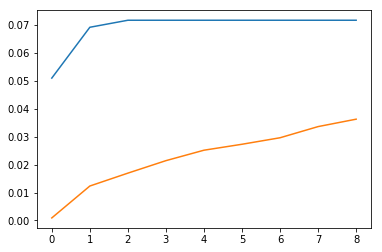

test days: 1460 - 1519
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       7.2 %  	       -0.9 %	     25 	 


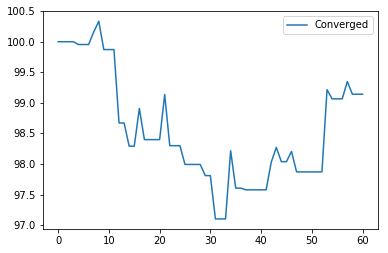

Converged 	decision vars: 2 	return -0.9
+ day chg in FXE
+ GLDFXB corr


Trial 23.0 
Training days: 1460 - 1519 
Testing days: 1520 - 1579 

train days: 1460 - 1519
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.2 %  	 avg: -0.2 % 	 time: 4.27s
gen 2 	 max: 5.9 %  	 avg: 1.1 % 	 time: 4.35s
gen 3 	 max: 5.9 %  	 avg: 1.5 % 	 time: 4.38s
gen 4 	 max: 5.9 %  	 avg: 1.6 % 	 time: 4.5s
gen 5 	 max: 6.2 %  	 avg: 2.0 % 	 time: 4.28s
gen 6 	 max: 6.4 %  	 avg: 2.3 % 	 time: 4.11s
gen 7 	 max: 6.4 %  	 avg: 2.3 % 	 time: 4.31s
gen 8 	 max: 6.4 %  	 avg: 2.5 % 	 time: 4.18s
gen 9 	 max: 6.2 %  	 avg: 2.5 % 	 time: 4.4s
gen 10 	 max: 6.2 %  	 avg: 2.7 % 	 time: 4.28s
gen 11 	 max: 6.4 %  	 avg: 2.5 % 	 time: 5.01s
gen 12 	 max: 7.5 %  	 avg: 2.6 % 	 time: 4.43s
gen 13 	 max: 6.4 %  	 avg: 2.5 % 	 time: 4.43s
gen 14 	 max: 6.9 %  	 avg: 2.7 % 	 time: 4.54s
gen 15 	 max: 7.5 %  	 avg: 2.9 % 	 time: 5.84s
gen 16 	 max: 7.5 %  	 avg: 2.8 % 	 time: 4.32s
gen 17 	 max: 7.5

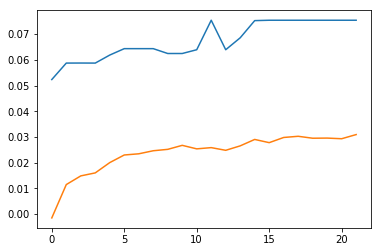

test days: 1520 - 1579
name	      dec vars	 train return	 test return	  trades	
Converged   	     5 	       7.5 %  	       1.9 %	     9 	 


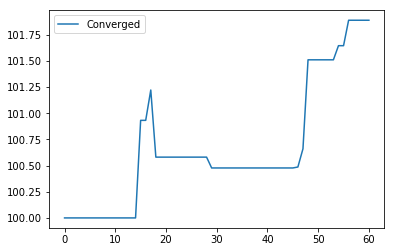

Converged 	decision vars: 5 	return 1.9
- wk chg in SPY
- wk chg in FXB
+ FXEGLD corr
- USO autocor
- CYB autocor


Trial 24.0 
Training days: 1520 - 1579 
Testing days: 1580 - 1639 

train days: 1520 - 1579
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.1 %  	 avg: 0.2 % 	 time: 3.97s
gen 2 	 max: 5.1 %  	 avg: 1.2 % 	 time: 4.19s
gen 3 	 max: 5.8 %  	 avg: 1.5 % 	 time: 4.13s
gen 4 	 max: 6.6 %  	 avg: 1.6 % 	 time: 4.11s
gen 5 	 max: 6.6 %  	 avg: 1.9 % 	 time: 4.56s
gen 6 	 max: 7.1 %  	 avg: 2.1 % 	 time: 5.09s
gen 7 	 max: 6.6 %  	 avg: 2.2 % 	 time: 4.88s
gen 8 	 max: 6.6 %  	 avg: 2.5 % 	 time: 4.98s
gen 9 	 max: 6.7 %  	 avg: 2.4 % 	 time: 4.37s
gen 10 	 max: 6.8 %  	 avg: 2.6 % 	 time: 4.22s
gen 11 	 max: 6.5 %  	 avg: 2.5 % 	 time: 4.68s
gen 12 	 max: 7.1 %  	 avg: 2.6 % 	 time: 4.27s
gen 13 	 max: 7.3 %  	 avg: 2.7 % 	 time: 4.36s
gen 14 	 max: 7.3 %  	 avg: 2.8 % 	 time: 4.46s
gen 15 	 max: 7.3 %  	 avg: 2.9 % 	 time: 4.47s
gen 16 	 max: 7.3 %  	

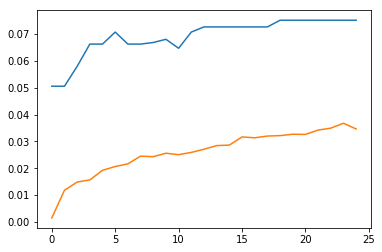

test days: 1580 - 1639
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       7.5 %  	       -0.8 %	     44 	 


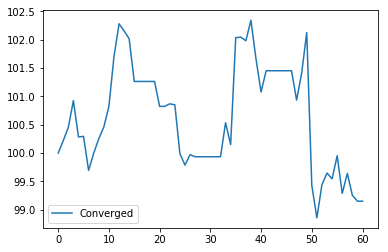

Converged 	decision vars: 2 	return -0.8
- SPYFXY corr
- GLD autocor


Trial 25.0 
Training days: 1580 - 1639 
Testing days: 1640 - 1699 

train days: 1580 - 1639
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.5 %  	 avg: -0.0 % 	 time: 4.25s
gen 2 	 max: 3.9 %  	 avg: 0.7 % 	 time: 4.3s
gen 3 	 max: 4.2 %  	 avg: 0.8 % 	 time: 4.36s
gen 4 	 max: 4.2 %  	 avg: 0.9 % 	 time: 4.27s
gen 5 	 max: 4.2 %  	 avg: 1.0 % 	 time: 4.28s
gen 6 	 max: 4.2 %  	 avg: 1.0 % 	 time: 4.31s
gen 7 	 max: 4.2 %  	 avg: 1.2 % 	 time: 4.55s
gen 8 	 max: 4.2 %  	 avg: 1.2 % 	 time: 4.43s
gen 9 	 max: 4.2 %  	 avg: 1.3 % 	 time: 4.5s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  39.25s
Max achieved at gen:  3
Stopping criteria in gen: 9


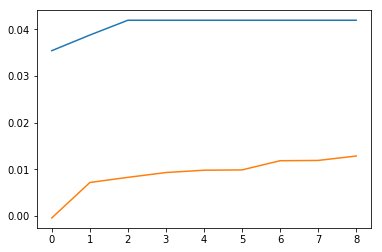

test days: 1640 - 1699
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       4.2 %  	       2.1 %	     19 	 


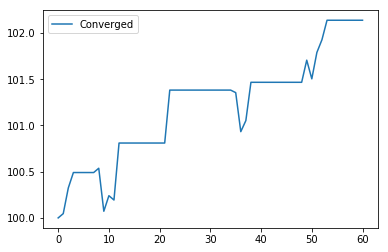

Converged 	decision vars: 3 	return 2.1
- wk chg in FXE
- mo chg in FXB
+ SPYUSO corr


Trial 26.0 
Training days: 1640 - 1699 
Testing days: 1700 - 1759 

train days: 1640 - 1699
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.9 %  	 avg: 0.0 % 	 time: 4.69s
gen 2 	 max: 3.5 %  	 avg: 0.5 % 	 time: 4.21s
gen 3 	 max: 4.0 %  	 avg: 0.7 % 	 time: 4.46s
gen 4 	 max: 4.0 %  	 avg: 0.8 % 	 time: 4.49s
gen 5 	 max: 4.0 %  	 avg: 0.9 % 	 time: 4.52s
gen 6 	 max: 4.0 %  	 avg: 0.9 % 	 time: 4.43s
gen 7 	 max: 4.0 %  	 avg: 1.1 % 	 time: 4.44s
gen 8 	 max: 4.0 %  	 avg: 1.0 % 	 time: 4.39s
gen 9 	 max: 4.0 %  	 avg: 1.1 % 	 time: 4.69s
gen 10 	 max: 4.0 %  	 avg: 1.2 % 	 time: 4.42s
gen 11 	 max: 4.0 %  	 avg: 1.2 % 	 time: 4.46s
gen 12 	 max: 4.7 %  	 avg: 1.3 % 	 time: 4.32s
gen 13 	 max: 4.7 %  	 avg: 1.4 % 	 time: 4.3s
gen 14 	 max: 4.5 %  	 avg: 1.4 % 	 time: 4.29s
gen 15 	 max: 4.8 %  	 avg: 1.5 % 	 time: 4.57s
gen 16 	 max: 4.8 %  	 avg: 1.6 % 	 time: 4.24s
gen

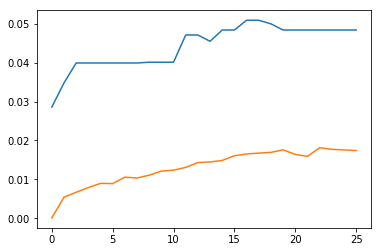

test days: 1700 - 1759
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       4.8 %  	       0.1 %	     19 	 


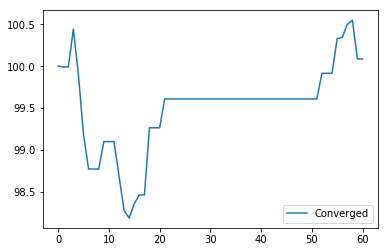

Converged 	decision vars: 2 	return 0.1
- day chg in FXB
- mo chg in FXB


Trial 27.0 
Training days: 1700 - 1759 
Testing days: 1760 - 1819 

train days: 1700 - 1759
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.5 %  	 avg: -0.4 % 	 time: 4.71s
gen 2 	 max: 2.0 %  	 avg: 0.2 % 	 time: 4.05s
gen 3 	 max: 2.0 %  	 avg: 0.2 % 	 time: 4.04s
gen 4 	 max: 2.3 %  	 avg: 0.3 % 	 time: 4.65s
gen 5 	 max: 2.9 %  	 avg: 0.4 % 	 time: 4.26s
gen 6 	 max: 2.3 %  	 avg: 0.4 % 	 time: 4.13s
gen 7 	 max: 3.4 %  	 avg: 0.3 % 	 time: 4.01s
gen 8 	 max: 3.4 %  	 avg: 0.4 % 	 time: 4.02s
gen 9 	 max: 3.0 %  	 avg: 0.5 % 	 time: 4.17s
gen 10 	 max: 3.4 %  	 avg: 0.5 % 	 time: 4.46s
gen 11 	 max: 3.4 %  	 avg: 0.4 % 	 time: 4.06s
gen 12 	 max: 3.4 %  	 avg: 0.5 % 	 time: 4.01s
gen 13 	 max: 3.4 %  	 avg: 0.6 % 	 time: 4.03s
gen 14 	 max: 3.5 %  	 avg: 0.6 % 	 time: 4.01s
gen 15 	 max: 4.2 %  	 avg: 0.6 % 	 time: 4.0s
gen 16 	 max: 4.2 %  	 avg: 0.7 % 	 time: 4.18s
gen 17 	 max: 4

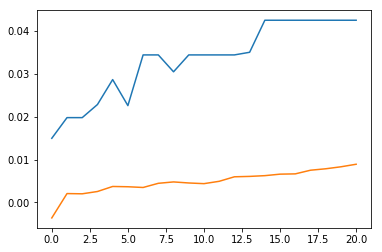

test days: 1760 - 1819
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       4.2 %  	       -1.3 %	     1 	 


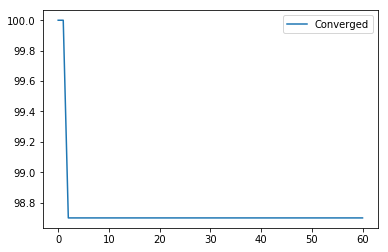

Converged 	decision vars: 3 	return -1.3
- wk chg in SPY
- BNDUSO corr
+ BND autocor


Trial 28.0 
Training days: 1760 - 1819 
Testing days: 1820 - 1879 

train days: 1760 - 1819
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.4 %  	 avg: 0.1 % 	 time: 4.21s
gen 2 	 max: 5.9 %  	 avg: 1.2 % 	 time: 4.33s
gen 3 	 max: 6.4 %  	 avg: 1.6 % 	 time: 4.38s
gen 4 	 max: 6.4 %  	 avg: 1.9 % 	 time: 4.41s
gen 5 	 max: 6.5 %  	 avg: 2.3 % 	 time: 4.44s
gen 6 	 max: 6.5 %  	 avg: 2.6 % 	 time: 4.64s
gen 7 	 max: 6.5 %  	 avg: 2.6 % 	 time: 5.09s
gen 8 	 max: 6.5 %  	 avg: 2.7 % 	 time: 4.36s
gen 9 	 max: 7.0 %  	 avg: 2.8 % 	 time: 4.54s
gen 10 	 max: 7.0 %  	 avg: 3.0 % 	 time: 4.43s
gen 11 	 max: 7.0 %  	 avg: 3.0 % 	 time: 4.58s
gen 12 	 max: 7.0 %  	 avg: 3.3 % 	 time: 4.37s
gen 13 	 max: 6.6 %  	 avg: 3.2 % 	 time: 5.4s
gen 14 	 max: 6.6 %  	 avg: 3.3 % 	 time: 5.35s
gen 15 	 max: 7.0 %  	 avg: 3.4 % 	 time: 4.75s
gen 16 	 max: 7.0 %  	 avg: 3.3 % 	 time: 5.4s
gen 1

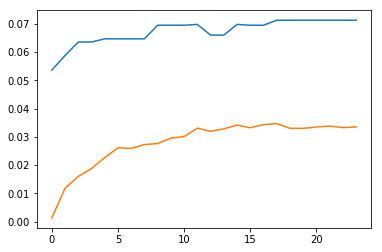

test days: 1820 - 1879
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       7.1 %  	       0.9 %	     33 	 


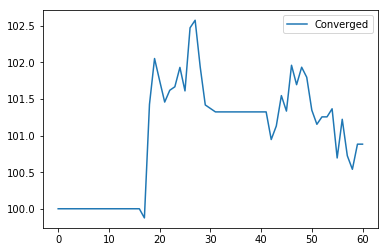

Converged 	decision vars: 4 	return 0.9
- wk chg in USO
+ GLDBND corr
+ GLDUSO corr
+ BNDFXY corr


Trial 29.0 
Training days: 1820 - 1879 
Testing days: 1880 - 1939 

train days: 1820 - 1879
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.1 %  	 avg: 0.2 % 	 time: 4.02s
gen 2 	 max: 5.4 %  	 avg: 1.2 % 	 time: 4.15s
gen 3 	 max: 5.5 %  	 avg: 1.4 % 	 time: 4.16s
gen 4 	 max: 6.2 %  	 avg: 1.6 % 	 time: 4.16s
gen 5 	 max: 6.2 %  	 avg: 1.8 % 	 time: 4.16s
gen 6 	 max: 6.5 %  	 avg: 1.9 % 	 time: 4.26s
gen 7 	 max: 6.5 %  	 avg: 2.2 % 	 time: 4.26s
gen 8 	 max: 7.2 %  	 avg: 2.4 % 	 time: 4.29s
gen 9 	 max: 7.7 %  	 avg: 2.5 % 	 time: 4.29s
gen 10 	 max: 7.7 %  	 avg: 2.5 % 	 time: 4.34s
gen 11 	 max: 7.7 %  	 avg: 2.6 % 	 time: 4.29s
gen 12 	 max: 7.7 %  	 avg: 2.8 % 	 time: 4.32s
gen 13 	 max: 7.7 %  	 avg: 2.8 % 	 time: 4.31s
gen 14 	 max: 7.7 %  	 avg: 2.9 % 	 time: 4.35s
gen 15 	 max: 7.9 %  	 avg: 3.2 % 	 time: 4.3s
gen 16 	 max: 7.9 %  	 avg: 3.3 % 	 tim

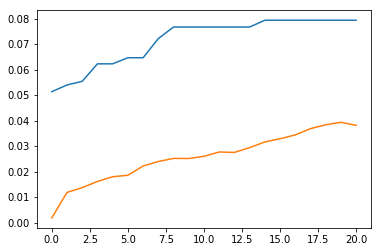

test days: 1880 - 1939
name	      dec vars	 train return	 test return	  trades	
Converged   	     5 	       7.9 %  	       0 %	     0 	 


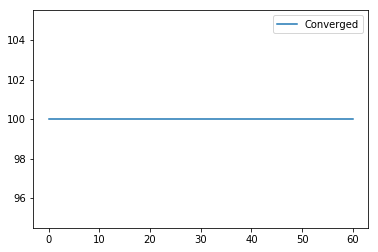

Converged 	decision vars: 5 	return 0
- SPYBND corr
+ GLDFXB corr
- USOCYB corr
+ FXE autocor
+ FXY autocor


Trial 30.0 
Training days: 1880 - 1939 
Testing days: 1940 - 1999 

train days: 1880 - 1939
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 8.5 %  	 avg: 0.2 % 	 time: 4.0s
gen 2 	 max: 8.5 %  	 avg: 1.5 % 	 time: 4.12s
gen 3 	 max: 8.5 %  	 avg: 2.2 % 	 time: 4.16s
gen 4 	 max: 8.5 %  	 avg: 3.0 % 	 time: 4.24s
gen 5 	 max: 8.5 %  	 avg: 3.5 % 	 time: 4.23s
gen 6 	 max: 8.5 %  	 avg: 4.1 % 	 time: 4.25s
gen 7 	 max: 8.5 %  	 avg: 4.4 % 	 time: 4.25s
gen 8 	 max: 8.5 %  	 avg: 4.7 % 	 time: 4.28s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  33.57s
Max achieved at gen:  1
Stopping criteria in gen: 8


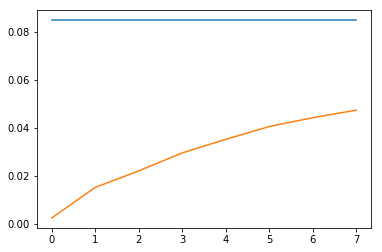

test days: 1940 - 1999
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       8.5 %  	       -1.3 %	     29 	 


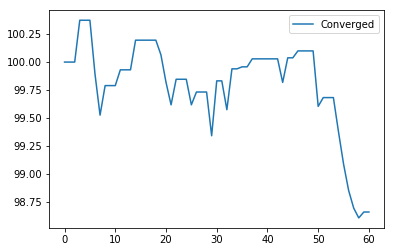

Converged 	decision vars: 2 	return -1.3
- day chg in FXE
+ FXBCYB corr


Trial 31.0 
Training days: 1940 - 1999 
Testing days: 2000 - 2059 

train days: 1940 - 1999
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 2.9 %  	 avg: -0.1 % 	 time: 4.0s
gen 2 	 max: 2.9 %  	 avg: 0.6 % 	 time: 4.11s
gen 3 	 max: 3.4 %  	 avg: 0.6 % 	 time: 4.12s
gen 4 	 max: 3.7 %  	 avg: 0.7 % 	 time: 4.15s
gen 5 	 max: 3.7 %  	 avg: 0.8 % 	 time: 4.15s
gen 6 	 max: 3.7 %  	 avg: 0.8 % 	 time: 4.15s
gen 7 	 max: 3.7 %  	 avg: 1.0 % 	 time: 4.18s
gen 8 	 max: 3.7 %  	 avg: 1.0 % 	 time: 4.19s
gen 9 	 max: 3.5 %  	 avg: 1.0 % 	 time: 4.18s
gen 10 	 max: 3.6 %  	 avg: 1.0 % 	 time: 4.16s
gen 11 	 max: 3.5 %  	 avg: 1.1 % 	 time: 4.11s
gen 12 	 max: 3.5 %  	 avg: 1.2 % 	 time: 4.09s
gen 13 	 max: 3.8 %  	 avg: 1.2 % 	 time: 4.11s
gen 14 	 max: 3.7 %  	 avg: 1.3 % 	 time: 4.1s
gen 15 	 max: 3.8 %  	 avg: 1.4 % 	 time: 4.12s
gen 16 	 max: 3.8 %  	 avg: 1.5 % 	 time: 4.25s
gen 17 	 max: 3.8

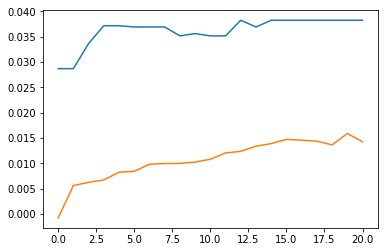

test days: 2000 - 2059
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       3.8 %  	       0 %	     0 	 


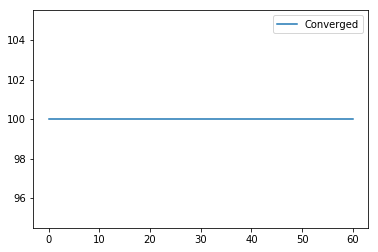

Converged 	decision vars: 3 	return 0
+ day chg in FXE
+ wk chg in FXY
- FXE autocor


Trial 32.0 
Training days: 2000 - 2059 
Testing days: 2060 - 2119 

train days: 2000 - 2059
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 5.3 %  	 avg: 0.2 % 	 time: 4.02s
gen 2 	 max: 6.6 %  	 avg: 1.1 % 	 time: 4.06s
gen 3 	 max: 6.6 %  	 avg: 1.3 % 	 time: 4.09s
gen 4 	 max: 6.6 %  	 avg: 1.7 % 	 time: 4.38s
gen 5 	 max: 6.6 %  	 avg: 1.9 % 	 time: 4.18s
gen 6 	 max: 6.6 %  	 avg: 2.3 % 	 time: 4.2s
gen 7 	 max: 6.6 %  	 avg: 2.6 % 	 time: 4.25s
gen 8 	 max: 6.6 %  	 avg: 2.8 % 	 time: 4.26s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  33.47s
Max achieved at gen:  2
Stopping criteria in gen: 8


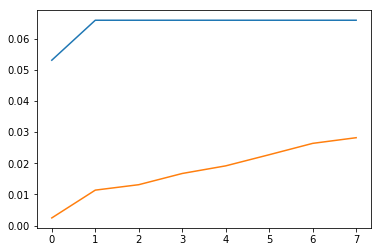

test days: 2060 - 2119
name	      dec vars	 train return	 test return	  trades	
Converged   	     2 	       6.6 %  	       -1.4 %	     20 	 


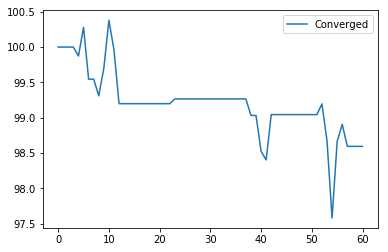

Converged 	decision vars: 2 	return -1.4
+ wk chg in FXY
+ FXEFXB corr


Trial 33.0 
Training days: 2060 - 2119 
Testing days: 2120 - 2179 

train days: 2060 - 2119
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 1.0 %  	 avg: -0.2 % 	 time: 4.0s
gen 2 	 max: 1.8 %  	 avg: 0.2 % 	 time: 3.98s
gen 3 	 max: 1.7 %  	 avg: 0.2 % 	 time: 4.15s
gen 4 	 max: 1.7 %  	 avg: 0.3 % 	 time: 4.03s
gen 5 	 max: 2.4 %  	 avg: 0.3 % 	 time: 3.97s
gen 6 	 max: 2.9 %  	 avg: 0.3 % 	 time: 3.98s
gen 7 	 max: 2.9 %  	 avg: 0.3 % 	 time: 4.04s
gen 8 	 max: 2.9 %  	 avg: 0.3 % 	 time: 3.98s
gen 9 	 max: 2.9 %  	 avg: 0.3 % 	 time: 4.02s
gen 10 	 max: 2.9 %  	 avg: 0.4 % 	 time: 4.0s
gen 11 	 max: 2.9 %  	 avg: 0.4 % 	 time: 4.03s
gen 12 	 max: 2.9 %  	 avg: 0.4 % 	 time: 5.44s
¯\_(ツ)_/¯  - stopping because 7 gens convergance
Total Time:  49.65s
Max achieved at gen:  6
Stopping criteria in gen: 12


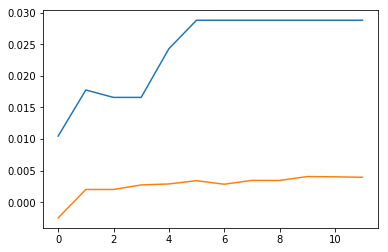

test days: 2120 - 2179
name	      dec vars	 train return	 test return	  trades	
Converged   	     4 	       2.9 %  	       0.5 %	     3 	 


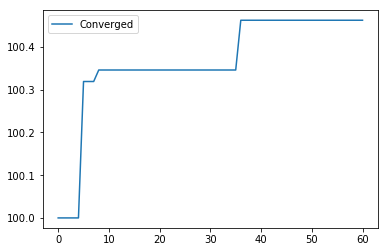

Converged 	decision vars: 4 	return 0.5
- day chg in GLD
- wk chg in CYB
+ USOCYB corr
+ USO autocor


Trial 34.0 
Training days: 2120 - 2179 
Testing days: 2180 - 2239 

train days: 2120 - 2179
Run:  500/0.9/10/20 	 Traders/Irrelevant/Mutation/Exponent
gen 1 	 max: 3.8 %  	 avg: -0.0 % 	 time: 4.19s
gen 2 	 max: 4.4 %  	 avg: 0.6 % 	 time: 5.8s
gen 3 	 max: 4.4 %  	 avg: 0.8 % 	 time: 4.1s
gen 4 	 max: 5.1 %  	 avg: 0.9 % 	 time: 4.15s
gen 5 	 max: 4.4 %  	 avg: 1.0 % 	 time: 4.36s
gen 6 	 max: 4.4 %  	 avg: 1.1 % 	 time: 4.32s
gen 7 	 max: 4.4 %  	 avg: 1.1 % 	 time: 4.12s
gen 8 	 max: 4.4 %  	 avg: 1.3 % 	 time: 4.12s
gen 9 	 max: 4.7 %  	 avg: 1.2 % 	 time: 4.14s
gen 10 	 max: 4.7 %  	 avg: 1.2 % 	 time: 4.12s
gen 11 	 max: 4.7 %  	 avg: 1.3 % 	 time: 4.12s
gen 12 	 max: 5.6 %  	 avg: 1.4 % 	 time: 4.15s
gen 13 	 max: 5.6 %  	 avg: 1.3 % 	 time: 4.15s
gen 14 	 max: 5.6 %  	 avg: 1.4 % 	 time: 4.13s
gen 15 	 max: 5.6 %  	 avg: 1.6 % 	 time: 4.15s
gen 16 	 max: 5.6 %  	 avg: 1.6 % 	 

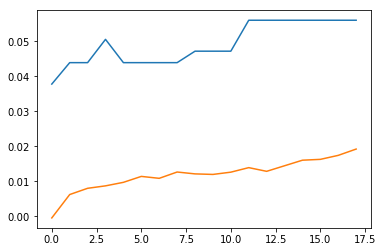

test days: 2180 - 2239
name	      dec vars	 train return	 test return	  trades	
Converged   	     3 	       5.6 %  	       -1.9 %	     19 	 


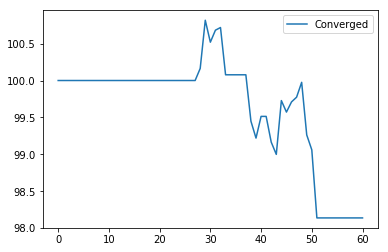

Converged 	decision vars: 3 	return -1.9
- mo chg in FXE
- FXYCYB corr
- FXY autocor




In [44]:
trainperiod = 60
testperiod = 60 
start_day = 140 #train on "new" data
end_day = start_day + trainperiod-1         
n_tests = int(len(range(start_day,len(All_bin)-trainperiod-testperiod, testperiod)) )


equity_wft = [100]




print(n_tests, 'trials \nTraining period:', trainperiod,'trading days\nTesting period:',testperiod,'trading days\n')

for p in range(start_day,len(All_bin)-trainperiod-testperiod, testperiod):
    
    start_day = p  #update start day, etc from start day variable outside loop
    end_day = start_day + trainperiod-1         
    test_start_day=end_day+1
    test_end_day=test_start_day + testperiod -1
    print('Trial',(p-trainperiod-20)/testperiod,
          '\nTraining days:',start_day,'-',end_day,
          '\nTesting days:',test_start_day,'-',test_end_day,'\n')
    
    
    Train(n_traders = n_traders, 
          irrelevant = irrelevant,
          Mutation = Mutation,  
          weight_exponent = weight_exponent, 
          start_day=start_day, 
          end_day=end_day, 
          stopper=stopper,
          )
    
    
    Test(test_start_day, test_end_day)
    
    #creates equity curve as if the trader bets 100 units every time
    for day in range(test_start_day, test_end_day+1):
        if day in Tester_list[0].trade_dates:
            equity_wft.append(equity_wft[-1]+Tester_list[0].trades[Tester_list[0].trade_dates.index(day)]*100)

        else:
            equity_wft.append(equity_wft[-1])

    




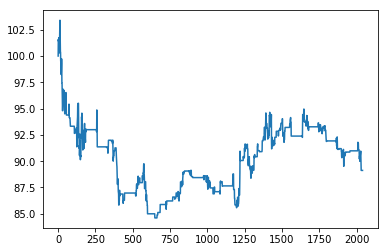

In [45]:
plt.plot(equity_wft)#, label=i.name)
plt.show()

# Bonus code

In [38]:
Dan_strat = np.empty(shape=[Variables])
# All_bin.columns = ['FXE',           'SPY',      'GLD',      'BND',      'USO',      'FXB',      'FXY',      'CYB', 
#                    'W_FXE',       'W_SPY',    'W_GLD',    'W_BND',    'W_USO',    'W_FXB',    'W_FXY',    'W_CYB', 
#                    'M_FXE',       'M_SPY',    'M_GLD',    'M_BND',    'M_USO',    'M_FXB',    'M_FXY',    'M_CYB', 
#                                'c_FXESPY', 'c_FXEGLD', 'c_FXEBND', 'c_FXEUSO', 'c_FXEFXB', 'c_FXEFXY', 'c_FXECYB', 
#                                            'c_SPYGLD', 'c_SPYBND', 'c_SPYUSO', 'c_SPYFXB', 'c_SPYFXY', 'c_SPYCYB', 
#                                                        'c_GLDBND', 'c_GLDUSO', 'c_GLDFXB', 'c_GLDFXY', 'c_GLDCYB', 
#                                                                    'c_BNDUSO', 'c_BNDFXB', 'c_BNDFXY', 'c_BNDCYB', 
#                                                                                'c_USOFXB', 'c_USOFXY', 'c_USOCYB', 
#                                                                                            'c_FXBFXY', 'c_FXBCYB',
#                                                                                                        'c_FXYCYB', 
#                    'ac_FXE',     'ac_SPY',   'ac_GLD',   'ac_BND',   'ac_USO',   'ac_FXB',   'ac_FXY',   'ac_CYB']

Dan_strat = np.array([ -1,  0,  0,  0,  0,  0,  0,  0,
                       1,  0,  0,  0,  0,  -1,  0,  0,
                       0,  0,  0,  0,  0,  0,  0,  0,
                           0,  0,  0,  0,  0,  0,  0,
                               0,  0,  0,  0,  0,  0,  
                                   0,  0,  0,  0,  0,
                                       0,  0,  0,  0,
                                           0,  0,  0,
                                               0,  0,
                                                   0,
                       -1,  0,  0,  0,  0,  0,  0,  0])
create_testers()
DANvsGA = Tester('DANvsGA',Dan_strat,np.nan)
Tester_list.append(DANvsGA)
test_fitness(25, 2000, Tester_list)
sum(DANvsGA.trades)

0.07141931180426786